In [1]:
import calendar as cld

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt  # New plot library (https://proplot.readthedocs.io/en/latest/)

pplt.rc[
    "savefig.dpi"
] = 300  # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import matplotlib as mpl
from numba import njit, prange
from scipy.stats import chi2

mpl.rcParams["hatch.linewidth"] = 0.05  # previous pdf hatch linewidth
import sys

from matplotlib.dates import DateFormatter
from scipy.stats import linregress

In [2]:
normal_format = {
    "gridlinewidth": 0.1,
    "gridcolor": "gray8",
    "gridalpha": 0.5,
    "coast": True,
    "borders": True,
    "reso": "hi",
    "labels": True,
    "lonlines": 2,
    "latlines": 2,
    "abc": False,
    "latlim": [43.0, 48.5],
    "lonlim": [4.0, 16.0],
}
multiplot_format = {
    "gridlinewidth": 0.1,
    "gridcolor": "gray8",
    "gridalpha": 0.5,
    "coast": True,
    "borders": True,
    "reso": "hi",
    "labels": False,
    "lonlines": 2,
    "latlines": 2,
    "abc": False,
    "latlim": [43.0, 48.5],
    "lonlim": [4.0, 16.0],
}

imin = 32
imax = -30
jmin = 20
jmax = -15
ds = xr.open_dataset("/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc")
lon = ds.LON[jmin:jmax, imin:imax]
lat = ds.LAT[jmin:jmax, imin:imax]
H = np.array(ds.SH[jmin:jmax, imin:imax])

seasons = ["DJF", "MAM", "JJA", "SON"]

In [3]:
ds_aerosols = xr.open_dataset(
    "/bettik/castelli/data/aerosols/aerosol_cams_climatology_49r2_1951-2019_4D.nc"
)

print(sys.getsizeof(ds_aerosols))

112


In [4]:
ds_aerosols

<xarray.Dataset>
Dimensions:                          (epoch: 13, month: 12, lev: 21, lat: 61,
                                      lon: 120)
Coordinates:
  * epoch                            (epoch) int16 1955 1960 1965 ... 2010 2015
  * month                            (month) int16 1 2 3 4 5 6 7 8 9 10 11 12
  * lev                              (lev) int16 1 2 3 4 5 6 ... 17 18 19 20 21
  * lat                              (lat) float32 90.0 87.0 ... -87.0 -90.0
  * lon                              (lon) float32 0.0 3.0 6.0 ... 354.0 357.0
Data variables: (12/17)
    pressure                         (month, lev, lat, lon) float32 ...
    Sea_Salt_bin1                    (month, lev, lat, lon) float32 ...
    Sea_Salt_bin2                    (month, lev, lat, lon) float32 ...
    Sea_Salt_bin3                    (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin1                (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin2                (month, lev, lat, lon) float32 ...
    ...                               ...
    Sulfates                         (epoch, month, lev, lat, lon) float32 ...
    Nitrate_fine                     (epoch, month, lev, lat, lon) float32 ...
    Nitrate_coarse                   (epoch, month, lev, lat, lon) float32 ...
    Ammonium                         (epoch, month, lev, lat, lon) float32 ...
    Biogenic_Secondary_Organic       (epoch, month, lev, lat, lon) float32 ...
    Anthropogenic_Secondary_Organic  (epoch, month, lev, lat, lon) float32 ...
Attributes:
    creation_date:   September 2023
    reference:       SEAS6 documentation
    source:          1951-2019 48r1 control run without scaling (CEDS/GFED fo...
    title:           4D monthly-mean aerosol climatology derived from the CAM...
    institution:     European Centre for Medium-Range Weather Forecasts
    creator_name:    Tim Stockdale
    dimensionality:  4
    ifs_cycle:       49r2
    cams_ifs_cycle:  48r1
    format_version:  2
    comment:         This file contains the aerosol climatology used in the r...

/tmp/ipykernel_1991428/1264851366.py:1: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=18, large=16)
/tmp/ipykernel_1991428/1264851366.py:1: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=18, large=16)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


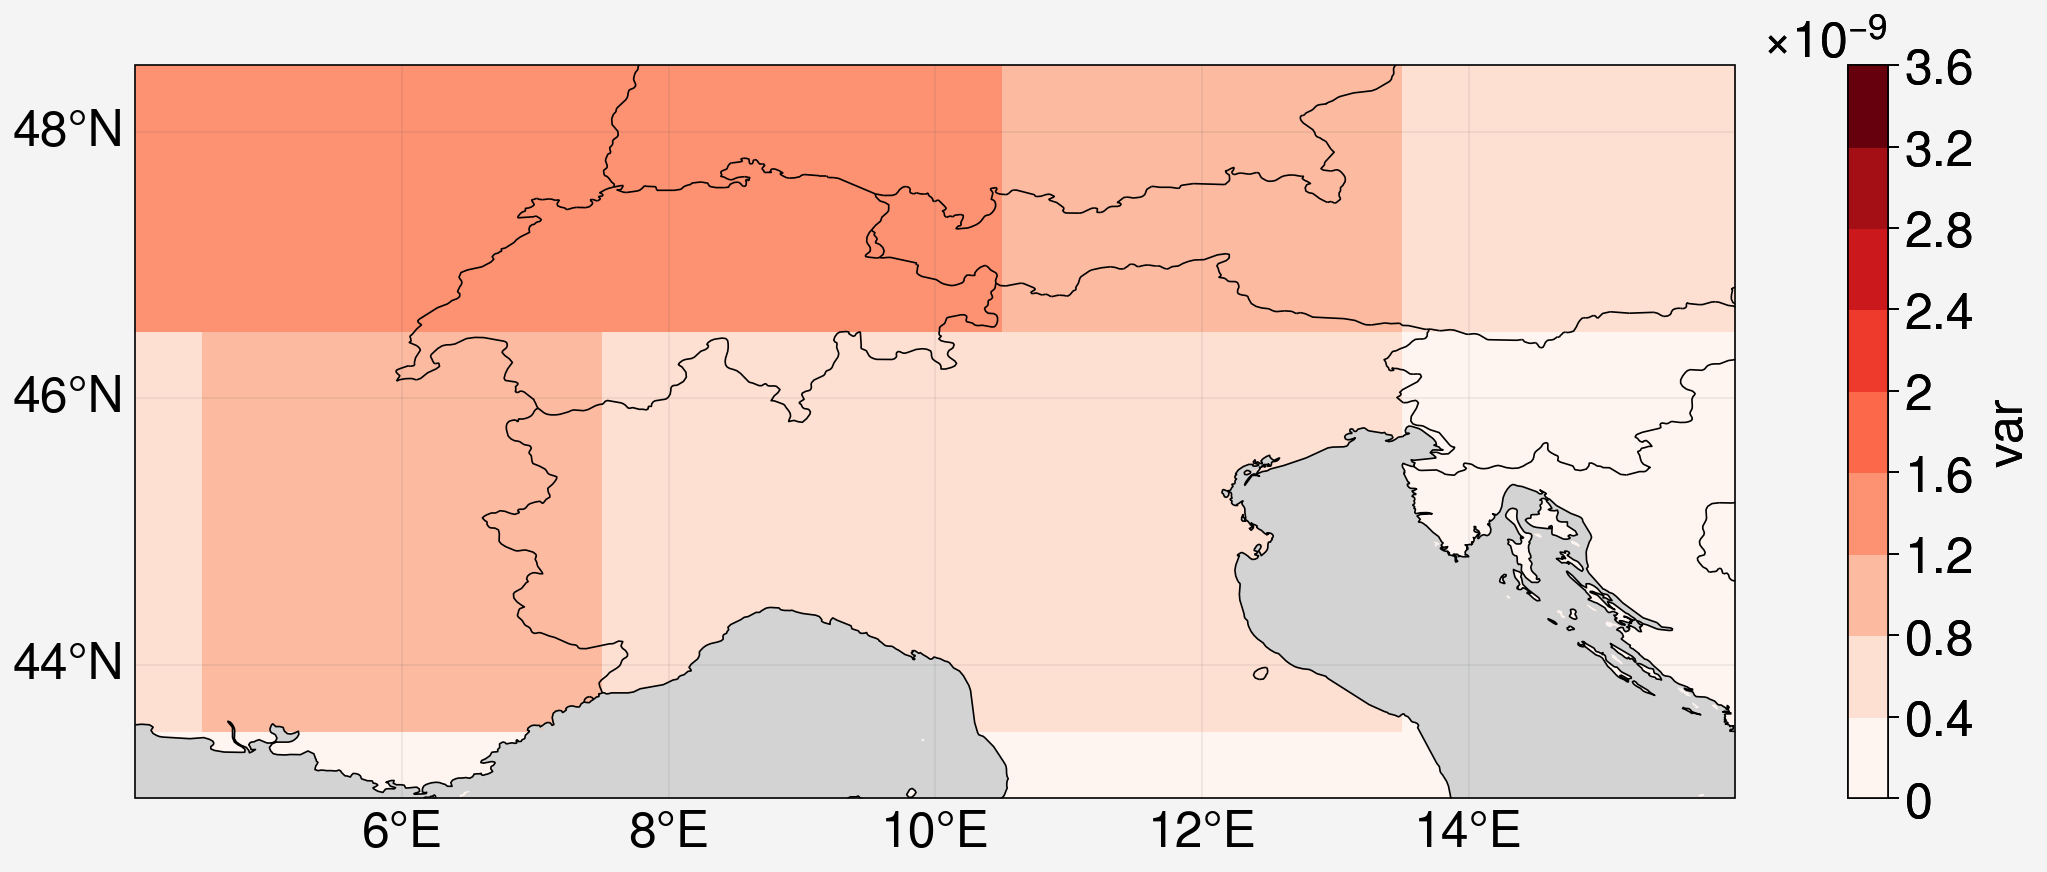

In [5]:
pplt.rc.update(small=18, large=16)

f, axs = pplt.subplots(proj="cyl", axwidth=8)


m = axs.pcolormesh(ds_aerosols.lon, ds_aerosols.lat, np.array(ds_aerosols.Black_Carbon_hydrophilic.isel(epoch=0).isel(month=0).isel(lev=20)), levels=10, cmap="Reds")
f.colorbar(m, label="var")

# axs.contour(lon, lat,alps)
# axs[2].contour(lon, lat,north_alps)
# axs[2].contour(lon, lat,south_alps)
axs.format(**normal_format)
axs.format(
    ocean=True, oceancolor="lightgray", reso="hi"
)  # , latlim=[40.,51.],lonlim=[0.,20.])

# axs.format(suptitle='Projection du réchauffement en été')

In [6]:
def yearly_interpolation(ds_aero, years):
    ds_YYYY = ds_aerosols.isel(epoch=0) + 0 * ds_aerosols.isel(epoch=1)
    multiplier = [0, 0.2, 0.4, 0.6, 0.8, 1]

    for year in range(years):
        print(year)
        if year == 0:
            continue
        j = year % 5
        # print("j = ",j)
        epo = year // 5
        # print("epo = ",epo)
        ds_YYYY = xr.concat(
            [
                ds_YYYY,
                ds_aerosols.isel(epoch=epo) * multiplier[-(j + 1)]
                + ds_aerosols.isel(epoch=epo + 1) * multiplier[j],
            ],
            dim="Year",
        )

    return ds_YYYY

### Whole period

In [ ]:
ds_aerosol_yearly = yearly_interpolation(ds_aerosols, years=60)

ds_aerosol_yearly

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
var_selection = ["Black_Carbon_hydrophilic", "Sulfates", "Nitrate_coarse", "Ammonium"]

f, axs = pplt.subplots(ncols=4)

for i in range(4):
    axs[i].plot(
        np.arange(1955, 2015, 1),
        ds_aerosol_yearly[var_selection[i]]
        .isel(lev=20)
        .mean(dim=["month", "lat", "lon"]),
        c="orange",
    )

    axs[i].scatter(
        np.arange(1955, 2016, 5),
        ds_aerosols[var_selection[i]].isel(lev=20).mean(dim=["month", "lat", "lon"]),
    )

axs.format(collabels=var_selection, xlabel="Years", ylabel="Mass mixing ratio (kg/kg)")

In [ ]:
f, axs = pplt.subplots(ncols=4, sharey=False)

for i in range(4):
    for year in range(6):
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosol_yearly[var_selection[i]]
            .isel(lev=20)
            .mean(dim=["lat", "lon"])[year],
            c="orange",
        )
    axs[i].plot(
        np.arange(1, 13, 1),
        ds_aerosols[var_selection[i]].isel(lev=20).mean(dim=["lat", "lon"])[0],
        linestyle="--",
        c="b",
    )
    axs[i].plot(
        np.arange(1, 13, 1),
        ds_aerosols[var_selection[i]].isel(lev=20).mean(dim=["lat", "lon"])[1],
        linestyle="--",
        c="b",
    )

axs.format(collabels=var_selection, xlabel="Month", ylabel="Mass mixing ratio (kg/kg)")

In [ ]:
# ds_aerosol_yearly.isel(Year=0)

# for i in range(60):
#    yr = i+1955
#    ds_aerosol_yearly.isel(Year=i).to_netcdf(path=f'/bettik/castelli/data/aerosols/yearly/aerosol_cams_climatology_49r2_4D_{yr}.nc')

In [ ]:
ds_aerosols_1955 = xr.open_dataset(
    "/bettik/castelli/data/aerosols/yearly/aerosol_cams_climatology_49r2_4D_1955.nc"
)

print(sys.getsizeof(ds_aerosols_1955))

In [ ]:
ds_aerosols_1960 = xr.open_dataset(
    "/bettik/castelli/data/aerosols/yearly/aerosol_cams_climatology_49r2_4D_1960.nc"
)
ds_aerosols_1960

In [ ]:
ds_aerosols_1965 = xr.open_dataset(
    "/bettik/castelli/data/aerosols/yearly/aerosol_cams_climatology_49r2_4D_1965.nc"
)

In [6]:
(ds_aerosols.isel(epoch=2) == ds_aerosols_1965).all()

NameError: name 'ds_aerosols' is not defined

In [ ]:
aerosol_cams_climatology_49r2_2015 = ds_aerosols.isel(epoch=12)

In [ ]:
#ds_aerosols.isel(epoch=12).to_netcdf(
#    path=f"/bettik/castelli/data/aerosols/yearly/aerosol_cams_climatology_49r2_4D_2015.nc"
#)

### Comparison to static aerosols

In [7]:
ds_aerosols = xr.open_dataset(
    "/bettik/castelli/data/aerosols/aerosol_cams_climatology_49r2_1951-2019_4D.nc"
)

ds_aerosols

<xarray.Dataset>
Dimensions:                          (epoch: 13, month: 12, lev: 21, lat: 61,
                                      lon: 120)
Coordinates:
  * epoch                            (epoch) int16 1955 1960 1965 ... 2010 2015
  * month                            (month) int16 1 2 3 4 5 6 7 8 9 10 11 12
  * lev                              (lev) int16 1 2 3 4 5 6 ... 17 18 19 20 21
  * lat                              (lat) float32 90.0 87.0 ... -87.0 -90.0
  * lon                              (lon) float32 0.0 3.0 6.0 ... 354.0 357.0
Data variables: (12/17)
    pressure                         (month, lev, lat, lon) float32 ...
    Sea_Salt_bin1                    (month, lev, lat, lon) float32 ...
    Sea_Salt_bin2                    (month, lev, lat, lon) float32 ...
    Sea_Salt_bin3                    (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin1                (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin2                (month, lev, lat, lon) float32 ...
    ...                               ...
    Sulfates                         (epoch, month, lev, lat, lon) float32 ...
    Nitrate_fine                     (epoch, month, lev, lat, lon) float32 ...
    Nitrate_coarse                   (epoch, month, lev, lat, lon) float32 ...
    Ammonium                         (epoch, month, lev, lat, lon) float32 ...
    Biogenic_Secondary_Organic       (epoch, month, lev, lat, lon) float32 ...
    Anthropogenic_Secondary_Organic  (epoch, month, lev, lat, lon) float32 ...
Attributes:
    creation_date:   September 2023
    reference:       SEAS6 documentation
    source:          1951-2019 48r1 control run without scaling (CEDS/GFED fo...
    title:           4D monthly-mean aerosol climatology derived from the CAM...
    institution:     European Centre for Medium-Range Weather Forecasts
    creator_name:    Tim Stockdale
    dimensionality:  4
    ifs_cycle:       49r2
    cams_ifs_cycle:  48r1
    format_version:  2
    comment:         This file contains the aerosol climatology used in the r...

In [8]:
ds_static = xr.open_dataset(
    "/home/castelli/MAR/src/datMAR/climatologies/aerosol_cams_climatology_43r3_v2_3D.nc"
)

ds_static

<xarray.Dataset>
Dimensions:                     (lev: 60, month: 12, lat: 61, lon: 120)
Coordinates:
  * lev                         (lev) int16 1 2 3 4 5 6 7 ... 55 56 57 58 59 60
  * month                       (month) int16 1 2 3 4 5 6 7 8 9 10 11 12
  * lat                         (lat) float32 90.0 87.0 84.0 ... -87.0 -90.0
  * lon                         (lon) float32 0.0 3.0 6.0 ... 351.0 354.0 357.0
Data variables:
    pressure                    (month, lev, lat, lon) float32 ...
    Sea_Salt_bin1               (month, lev, lat, lon) float32 ...
    Sea_Salt_bin2               (month, lev, lat, lon) float32 ...
    Sea_Salt_bin3               (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin1           (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin2           (month, lev, lat, lon) float32 ...
    Mineral_Dust_bin3           (month, lev, lat, lon) float32 ...
    Organic_Matter_hydrophilic  (month, lev, lat, lon) float32 ...
    Organic_Matter_hydrophobic  (month, lev, lat, lon) float32 ...
    Black_Carbon_hydrophilic    (month, lev, lat, lon) float32 ...
    Black_Carbon_hydrophobic    (month, lev, lat, lon) float32 ...
    Sulfates                    (month, lev, lat, lon) float32 ...
Attributes:
    creation_date:   Fri  5 May 10:45:05 BST 2017
    source:          2003-2011 IFS control run "gbst", with total aerosol opt...
    title:           3D monthly-mean aerosol climatology derived from the CAM...
    creator_name:    Alessio Bozzo
    institution:     European Centre for Medium-Range Weather Forecasts
    history:         Fri  5 May 10:45:05 BST 2017: Original data created by A...
    references:      Bozzo, A., A. Benedetti, J. Flemming, J., Z. Kipling and...
    ifs_cycle:       43r3
    dimensionality:  3
    format_version:  2
    comment:         This file contains the aerosol climatologies as a functi...

/tmp/ipykernel_1991428/1470663731.py:1: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=18, large=16)
/tmp/ipykernel_1991428/1470663731.py:1: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=18, large=16)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


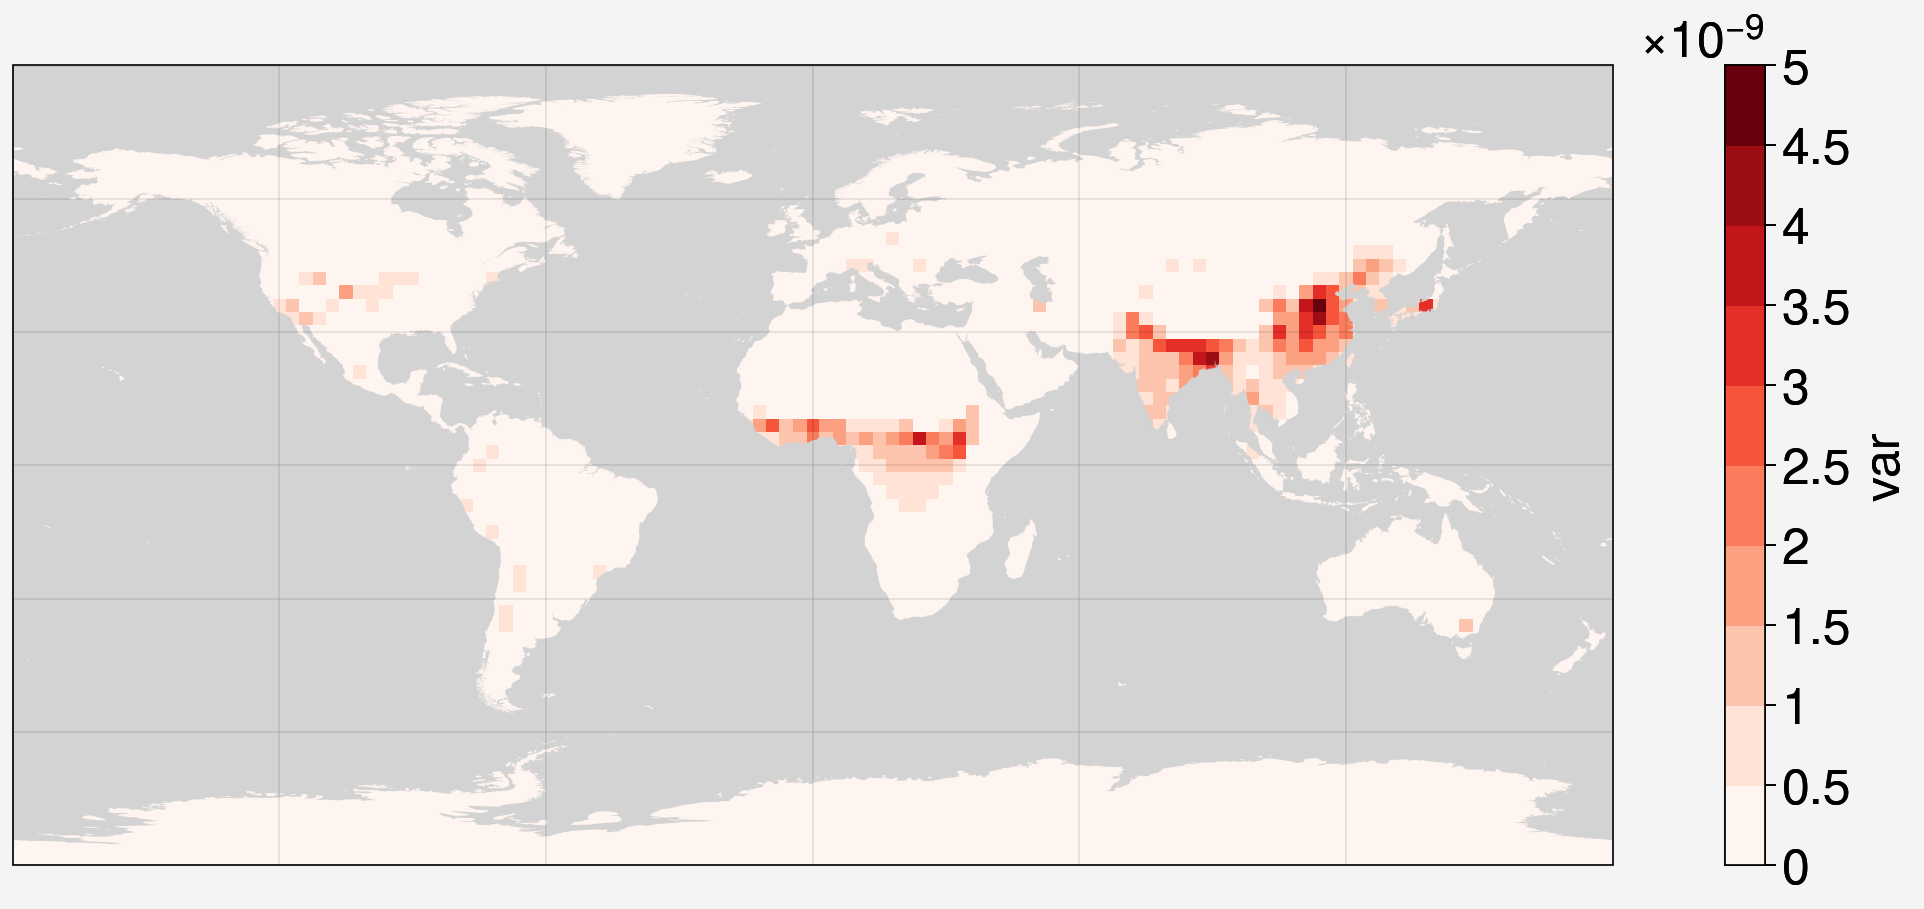

In [9]:
pplt.rc.update(small=18, large=16)

f, axs = pplt.subplots(proj="cyl", axwidth=8)


m = axs.pcolormesh(
    ds_static.lon,
    ds_static.lat,
    np.array(ds_static.Black_Carbon_hydrophilic.isel(month=0).isel(lev=59)),
    levels=10,
    cmap="Reds",
)
f.colorbar(m, label="var")

# axs.format(**normal_format)
axs.format(
    ocean=True, oceancolor="lightgray", reso="hi"
)  # , latlim=[40.,51.],lonlim=[0.,20.])

/tmp/ipykernel_1991428/596649912.py:1: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=14)
/tmp/ipykernel_1991428/596649912.py:1: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=14)


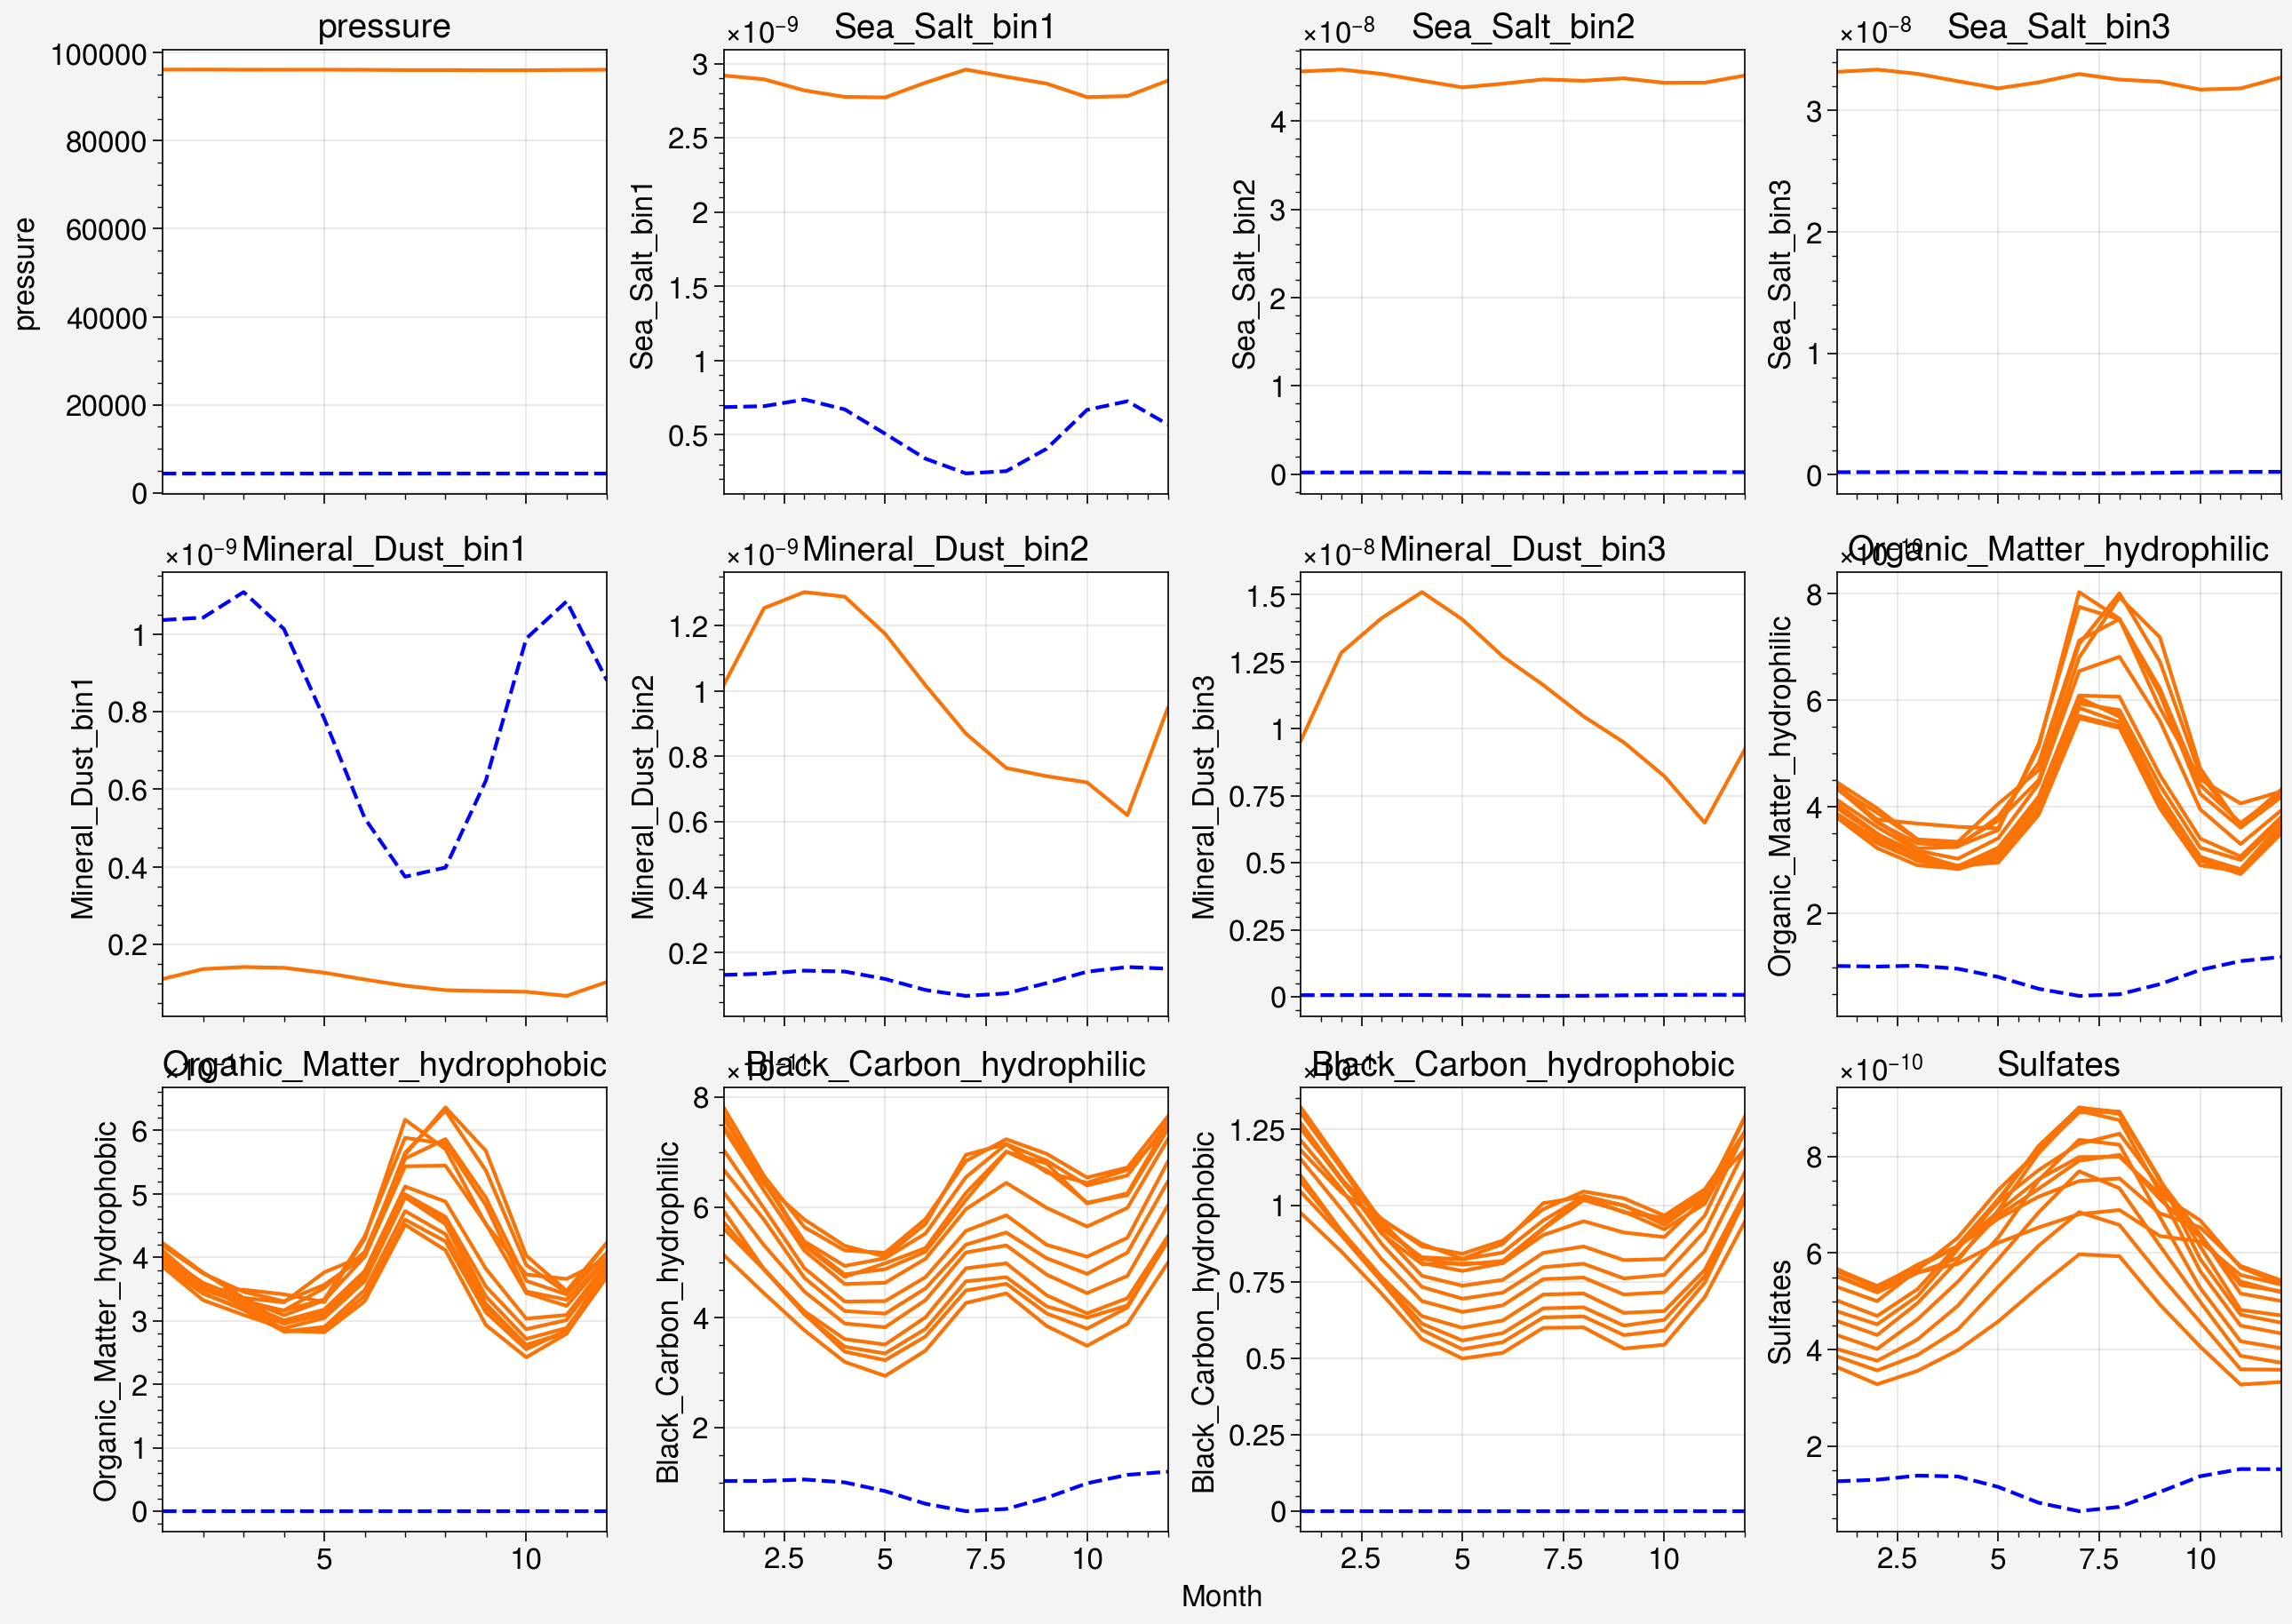

In [10]:
pplt.rc.update(small=12, large=14)

var_selection = [
    "pressure",
    "Sea_Salt_bin1",
    "Sea_Salt_bin2",
    "Sea_Salt_bin3",
    "Mineral_Dust_bin1",
    "Mineral_Dust_bin2",
    "Mineral_Dust_bin3",
    "Organic_Matter_hydrophilic",
    "Organic_Matter_hydrophobic",
    "Black_Carbon_hydrophilic",
    "Black_Carbon_hydrophobic",
    "Sulfates",
]

f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False)

level = 20

for i in range(12):
    axs[i].format(title=var_selection[i])
    axs[i].plot(
        np.arange(1, 13, 1),
        ds_static[var_selection[i]].isel(lev=level).mean(dim=["lat", "lon"]),
        linestyle="--",
        c="b",
    )
    if i < 7:
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosols[var_selection[i]].isel(lev=level).mean(dim=["lat", "lon"]),
            c="orange",
        )
    else:
        for epo in range(13):
            axs[i].plot(
                np.arange(1, 13, 1),
                ds_aerosols[var_selection[i]]
                .isel(epoch=epo)
                .isel(lev=level)
                .mean(dim=["lat", "lon"]),
                c="orange",
            )

axs.format(xlabel="Month")  # ,ylabel='Mass mixing ratio (kg/kg)')

/tmp/ipykernel_1991428/3750212712.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


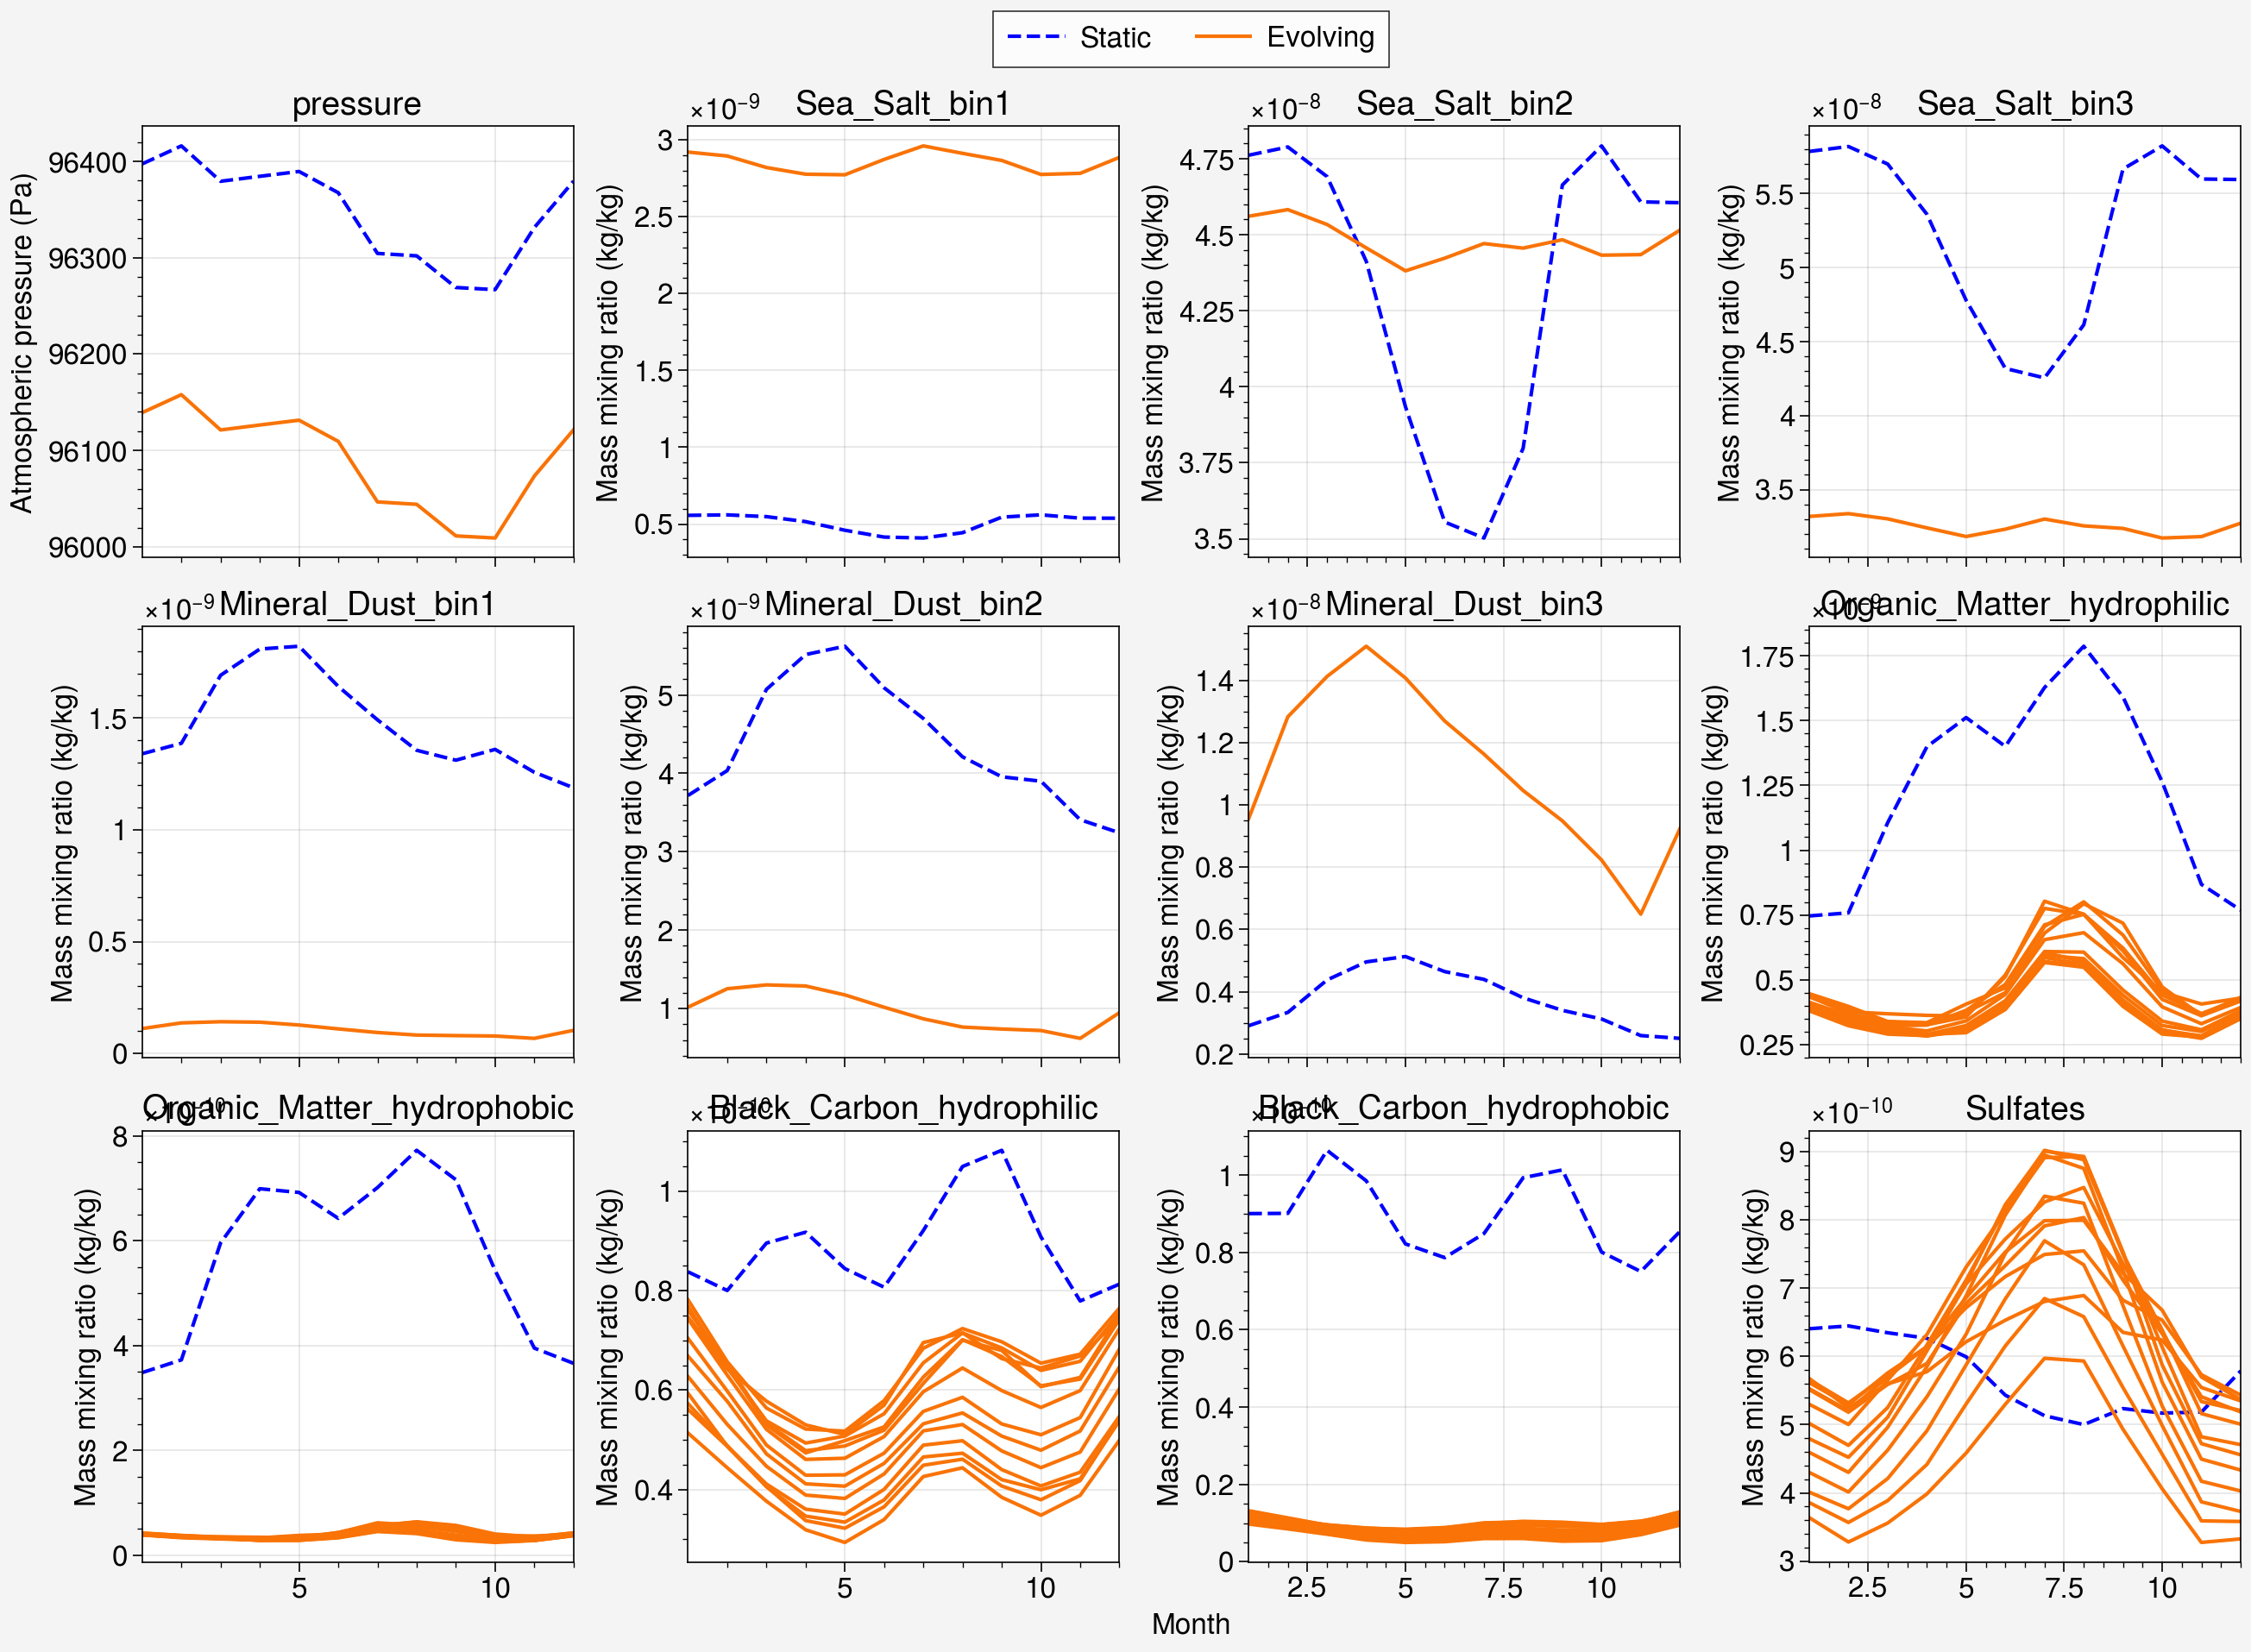

In [11]:
# pplt.rc.update(small=18, large=16)

var_selection = [
    "pressure",
    "Sea_Salt_bin1",
    "Sea_Salt_bin2",
    "Sea_Salt_bin3",
    "Mineral_Dust_bin1",
    "Mineral_Dust_bin2",
    "Mineral_Dust_bin3",
    "Organic_Matter_hydrophilic",
    "Organic_Matter_hydrophobic",
    "Black_Carbon_hydrophilic",
    "Black_Carbon_hydrophobic",
    "Sulfates",
]

f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False)

level = -1

for i in range(12):
    axs[i].format(title=var_selection[i])
    static = axs[i].plot(
        np.arange(1, 13, 1),
        ds_static[var_selection[i]].isel(lev=level).mean(dim=["lat", "lon"]),
        linestyle="--",
        c="b",
        label="Static",
    )
    if i < 7:
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosols[var_selection[i]].isel(lev=level).mean(dim=["lat", "lon"]),
            c="orange",
        )
    else:
        for epo in range(13):
            evolving = axs[i].plot(
                np.arange(1, 13, 1),
                ds_aerosols[var_selection[i]]
                .isel(epoch=epo)
                .isel(lev=level)
                .mean(dim=["lat", "lon"]),
                c="orange",
                label="Evolving",
            )

f.legend([static, evolving], loc="top")
axs.format(xlabel="Month", ylabel="Mass mixing ratio (kg/kg)")
axs[0].format(ylabel="Atmospheric pressure (Pa)")

#f.savefig("/bettik/castelli/figs/static_vs_evolving_aerosols2.png")
f.show()

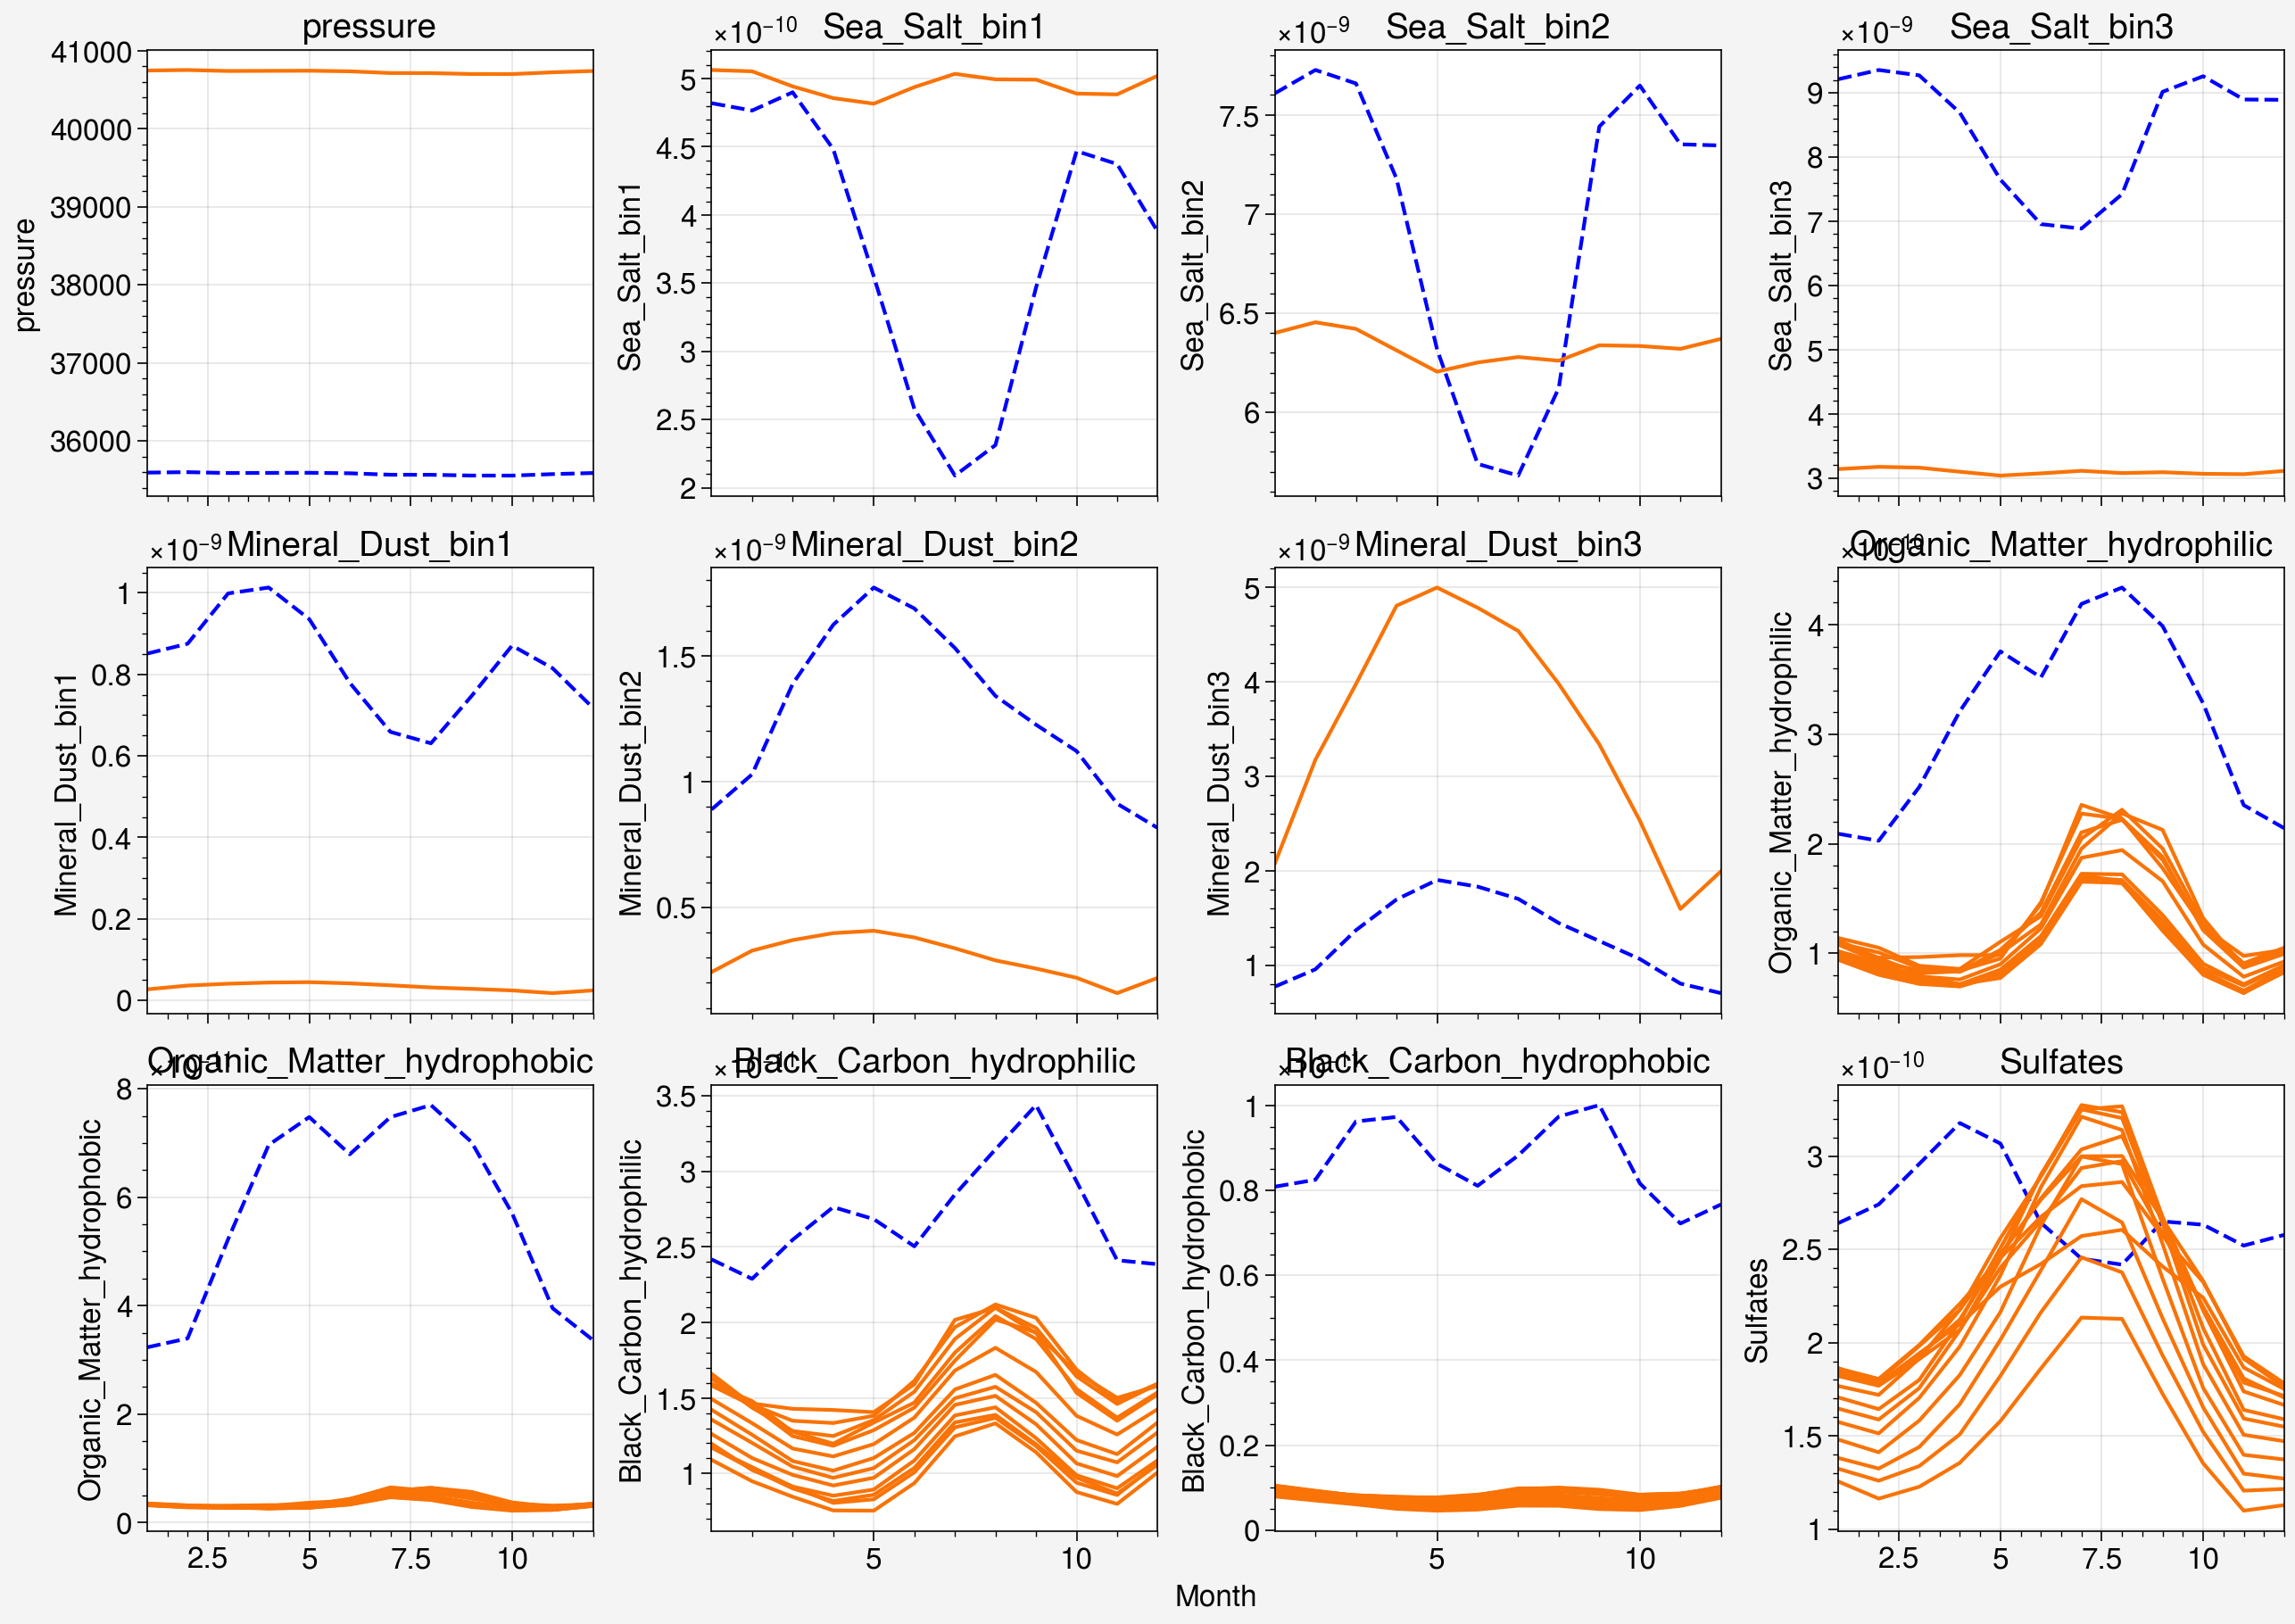

In [12]:
var_selection = [
    "pressure",
    "Sea_Salt_bin1",
    "Sea_Salt_bin2",
    "Sea_Salt_bin3",
    "Mineral_Dust_bin1",
    "Mineral_Dust_bin2",
    "Mineral_Dust_bin3",
    "Organic_Matter_hydrophilic",
    "Organic_Matter_hydrophobic",
    "Black_Carbon_hydrophilic",
    "Black_Carbon_hydrophobic",
    "Sulfates",
]

f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False)

for i in range(12):
    axs[i].format(title=var_selection[i])
    axs[i].plot(
        np.arange(1, 13, 1),
        ds_static[var_selection[i]].mean(dim=["lat", "lon", "lev"]),
        linestyle="--",
        c="b",
    )
    if i < 7:
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosols[var_selection[i]].mean(dim=["lat", "lon", "lev"]),
            c="orange",
        )
    else:
        for epo in range(13):
            axs[i].plot(
                np.arange(1, 13, 1),
                ds_aerosols[var_selection[i]]
                .isel(epoch=epo)
                .mean(dim=["lat", "lon", "lev"]),
                c="orange",
            )

axs.format(xlabel="Month")  # ,ylabel='Mass mixing ratio (kg/kg)')

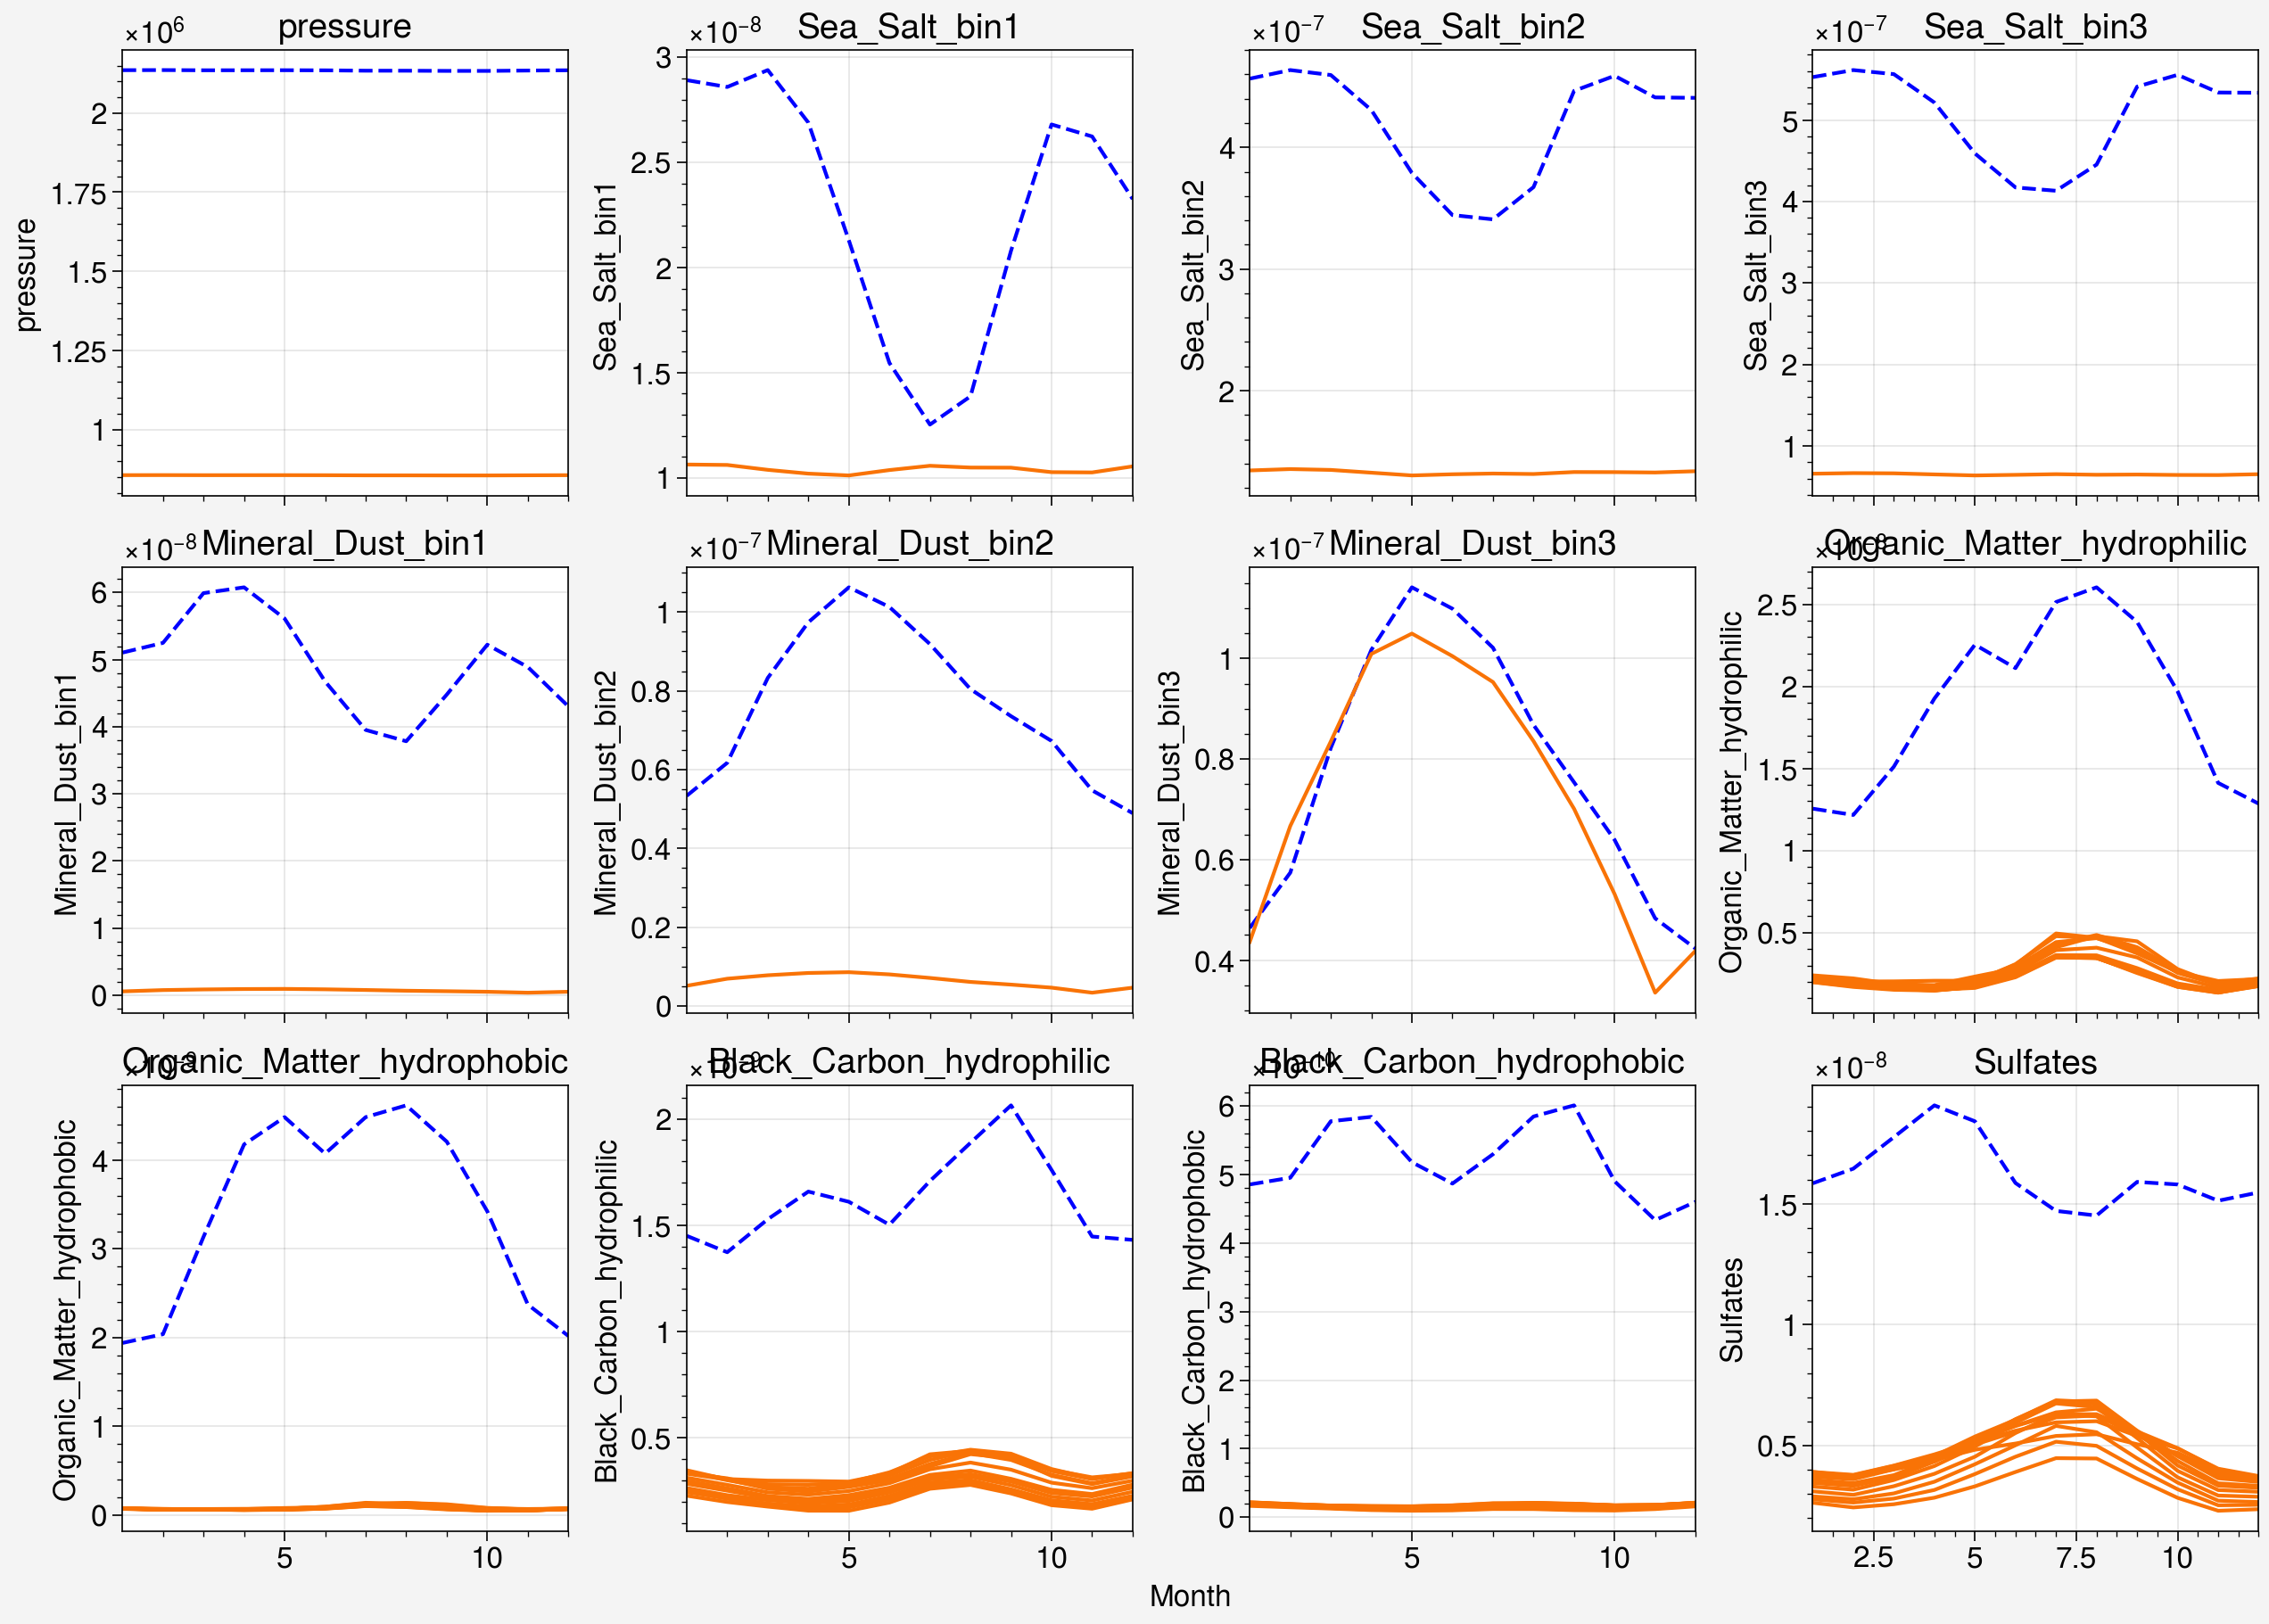

In [13]:
var_selection = [
    "pressure",
    "Sea_Salt_bin1",
    "Sea_Salt_bin2",
    "Sea_Salt_bin3",
    "Mineral_Dust_bin1",
    "Mineral_Dust_bin2",
    "Mineral_Dust_bin3",
    "Organic_Matter_hydrophilic",
    "Organic_Matter_hydrophobic",
    "Black_Carbon_hydrophilic",
    "Black_Carbon_hydrophobic",
    "Sulfates",
]

f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False)

for i in range(12):
    axs[i].format(title=var_selection[i])
    axs[i].plot(
        np.arange(1, 13, 1),
        ds_static[var_selection[i]].mean(dim=["lat", "lon"]).sum(dim="lev"),
        linestyle="--",
        c="b",
    )
    if i < 7:
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosols[var_selection[i]].mean(dim=["lat", "lon"]).sum(dim="lev"),
            c="orange",
        )
    else:
        for epo in range(13):
            axs[i].plot(
                np.arange(1, 13, 1),
                ds_aerosols[var_selection[i]]
                .isel(epoch=epo)
                .mean(dim=["lat", "lon"])
                .sum(dim="lev"),
                c="orange",
            )

axs.format(xlabel="Month")  # ,ylabel='Mass mixing ratio (kg/kg)')

### Interpolating to vertical levels

In [14]:
def p_to_z(P):
    p0 = 1013.25 # hPa
    gamma = 6.5*10**(-3) # K/m
    T0 = 288.5 # K
    g = 9.81 # m.s^-2
    R = 287 # J/kg/K
    altitude = T0/gamma*(1-(P/p0)**(gamma*R/g))
    return altitude

def z_to_p(H):
    p0 = 1013.25 # hPa
    gamma = 6.5*10**(-3) # K/m
    T0 = 288.5 # K
    g = 9.81 # m.s^-2
    R = 287 # J/kg/K
    pressure = p0*(1-gamma/T0*H)**(g/gamma/R)
    return pressure

In [15]:
ds_aerosols

<xarray.Dataset>
Dimensions:                          (epoch: 13, month: 12, lev: 21, lat: 61,
                                      lon: 120)
Coordinates:
  * epoch                            (epoch) int16 1955 1960 1965 ... 2010 2015
  * month                            (month) int16 1 2 3 4 5 6 7 8 9 10 11 12
  * lev                              (lev) int16 1 2 3 4 5 6 ... 17 18 19 20 21
  * lat                              (lat) float32 90.0 87.0 ... -87.0 -90.0
  * lon                              (lon) float32 0.0 3.0 6.0 ... 354.0 357.0
Data variables: (12/17)
    pressure                         (month, lev, lat, lon) float32 100.0 ......
    Sea_Salt_bin1                    (month, lev, lat, lon) float32 2.376e-16...
    Sea_Salt_bin2                    (month, lev, lat, lon) float32 1.001e-25...
    Sea_Salt_bin3                    (month, lev, lat, lon) float32 1e-25 ......
    Mineral_Dust_bin1                (month, lev, lat, lon) float32 1.32e-17 ...
    Mineral_Dust_bin2                (month, lev, lat, lon) float32 1.256e-17...
    ...                               ...
    Sulfates                         (epoch, month, lev, lat, lon) float32 ...
    Nitrate_fine                     (epoch, month, lev, lat, lon) float32 ...
    Nitrate_coarse                   (epoch, month, lev, lat, lon) float32 ...
    Ammonium                         (epoch, month, lev, lat, lon) float32 ...
    Biogenic_Secondary_Organic       (epoch, month, lev, lat, lon) float32 ...
    Anthropogenic_Secondary_Organic  (epoch, month, lev, lat, lon) float32 ...
Attributes:
    creation_date:   September 2023
    reference:       SEAS6 documentation
    source:          1951-2019 48r1 control run without scaling (CEDS/GFED fo...
    title:           4D monthly-mean aerosol climatology derived from the CAM...
    institution:     European Centre for Medium-Range Weather Forecasts
    creator_name:    Tim Stockdale
    dimensionality:  4
    ifs_cycle:       49r2
    cams_ifs_cycle:  48r1
    format_version:  2
    comment:         This file contains the aerosol climatology used in the r...

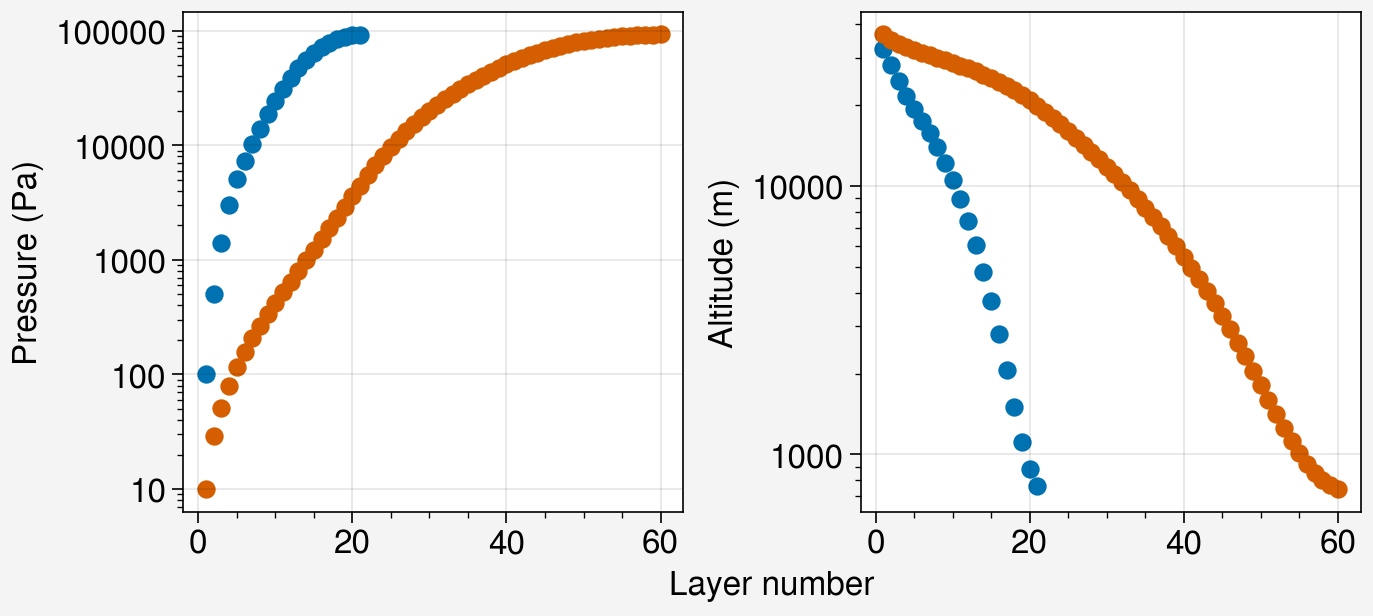

In [16]:
f, axs = pplt.subplots(ncols=2, sharey=False)


axs[0].scatter(ds_aerosols.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1))
axs[0].scatter(ds_static.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1))
axs[0].set_yscale('log')

axs[1].scatter(p_to_z(ds_aerosols.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1) / 100))
axs[1].scatter(p_to_z(ds_static.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1) / 100))
axs[1].set_yscale('log')

axs[1].format(ylabel="Altitude (m)")

In [17]:
#np.array(p_to_z(ds_static.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1) / 100))[::-1]

In [18]:
testing = np.interp(1000, np.array(p_to_z(ds_aerosols.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1) / 100))[::-1],
          np.array(ds_aerosols.Sulfates.sel(lat = 45).sel(lon = 9).sel(month = 1).sel(epoch=2015))[::-1])
testing

3.7810248508264074e-10

In [19]:
testing2 = np.interp(923.2023, np.array(ds_static.pressure.sel(lat = 45,lon = 9,month = 2))/100,
           np.array(ds_static.Sulfates.sel(lat = 45,lon = 9,month = 2)))
testing2

5.379567376303567e-09

In [20]:
xq = ds_aerosols.pressure.sel(lat = 45,lon = 9).isel(lev=-1)/100
x = ds_static.pressure.sel(lat=45, lon=9)/100
y = ds_static.Sulfates.sel(lat = 45,lon = 9)

testing3 = np.array([np.interp(xq[i], x[i], y[i]) for i in range(x.shape[0])])
testing3

array([3.91977741e-09, 5.37958177e-09, 4.91602567e-09, 4.91401383e-09,
       4.29466330e-09, 4.55312471e-09, 4.38318170e-09, 4.08487748e-09,
       4.62935154e-09, 3.54870657e-09, 2.47285285e-09, 2.53022853e-09])

In [21]:
ds_aerosols.pressure.sel(lat = 45,lon = 9).isel(lev=-1)/100

<xarray.DataArray 'pressure' (month: 12)>
array([924.65295, 923.2023 , 923.753  , 923.7151 , 924.94226, 925.7558 ,
       925.75806, 925.2861 , 927.2673 , 926.4799 , 924.79456, 924.6499 ],
      dtype=float32)
Coordinates:
  * month    (month) int16 1 2 3 4 5 6 7 8 9 10 11 12
    lev      int16 21
    lat      float32 45.0
    lon      float32 9.0

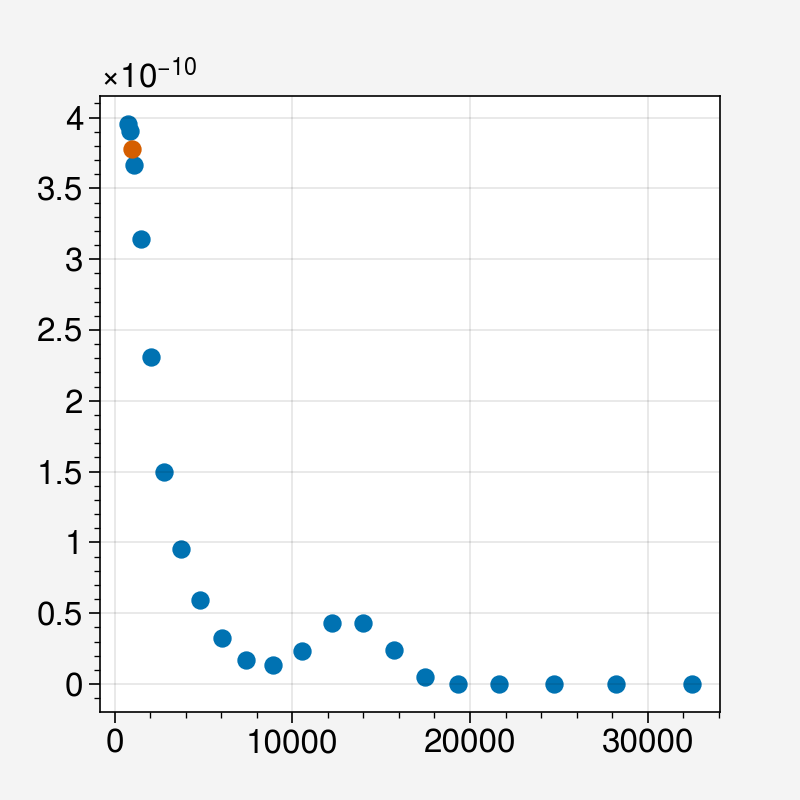

In [22]:
plt.scatter(np.array(p_to_z(ds_aerosols.pressure.sel(lat = 45).sel(lon = 9).sel(month = 1) / 100))[::-1],
            np.array(ds_aerosols.Sulfates.sel(lat = 45).sel(lon = 9).sel(month = 1).sel(epoch=2015))[::-1])
plt.scatter(1000, testing)

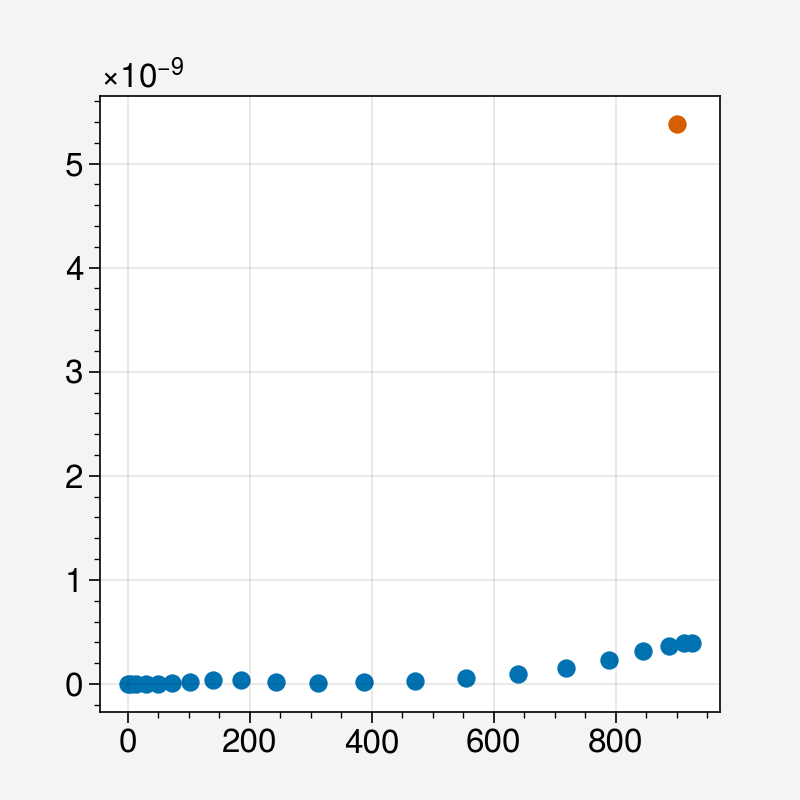

In [23]:
plt.scatter(np.array(ds_aerosols.pressure.sel(lat = 45, lon = 9, month = 1) / 100),
            np.array(ds_aerosols.Sulfates.sel(lat = 45, lon = 9, month = 1, epoch=2015)))
plt.scatter(900, testing2)

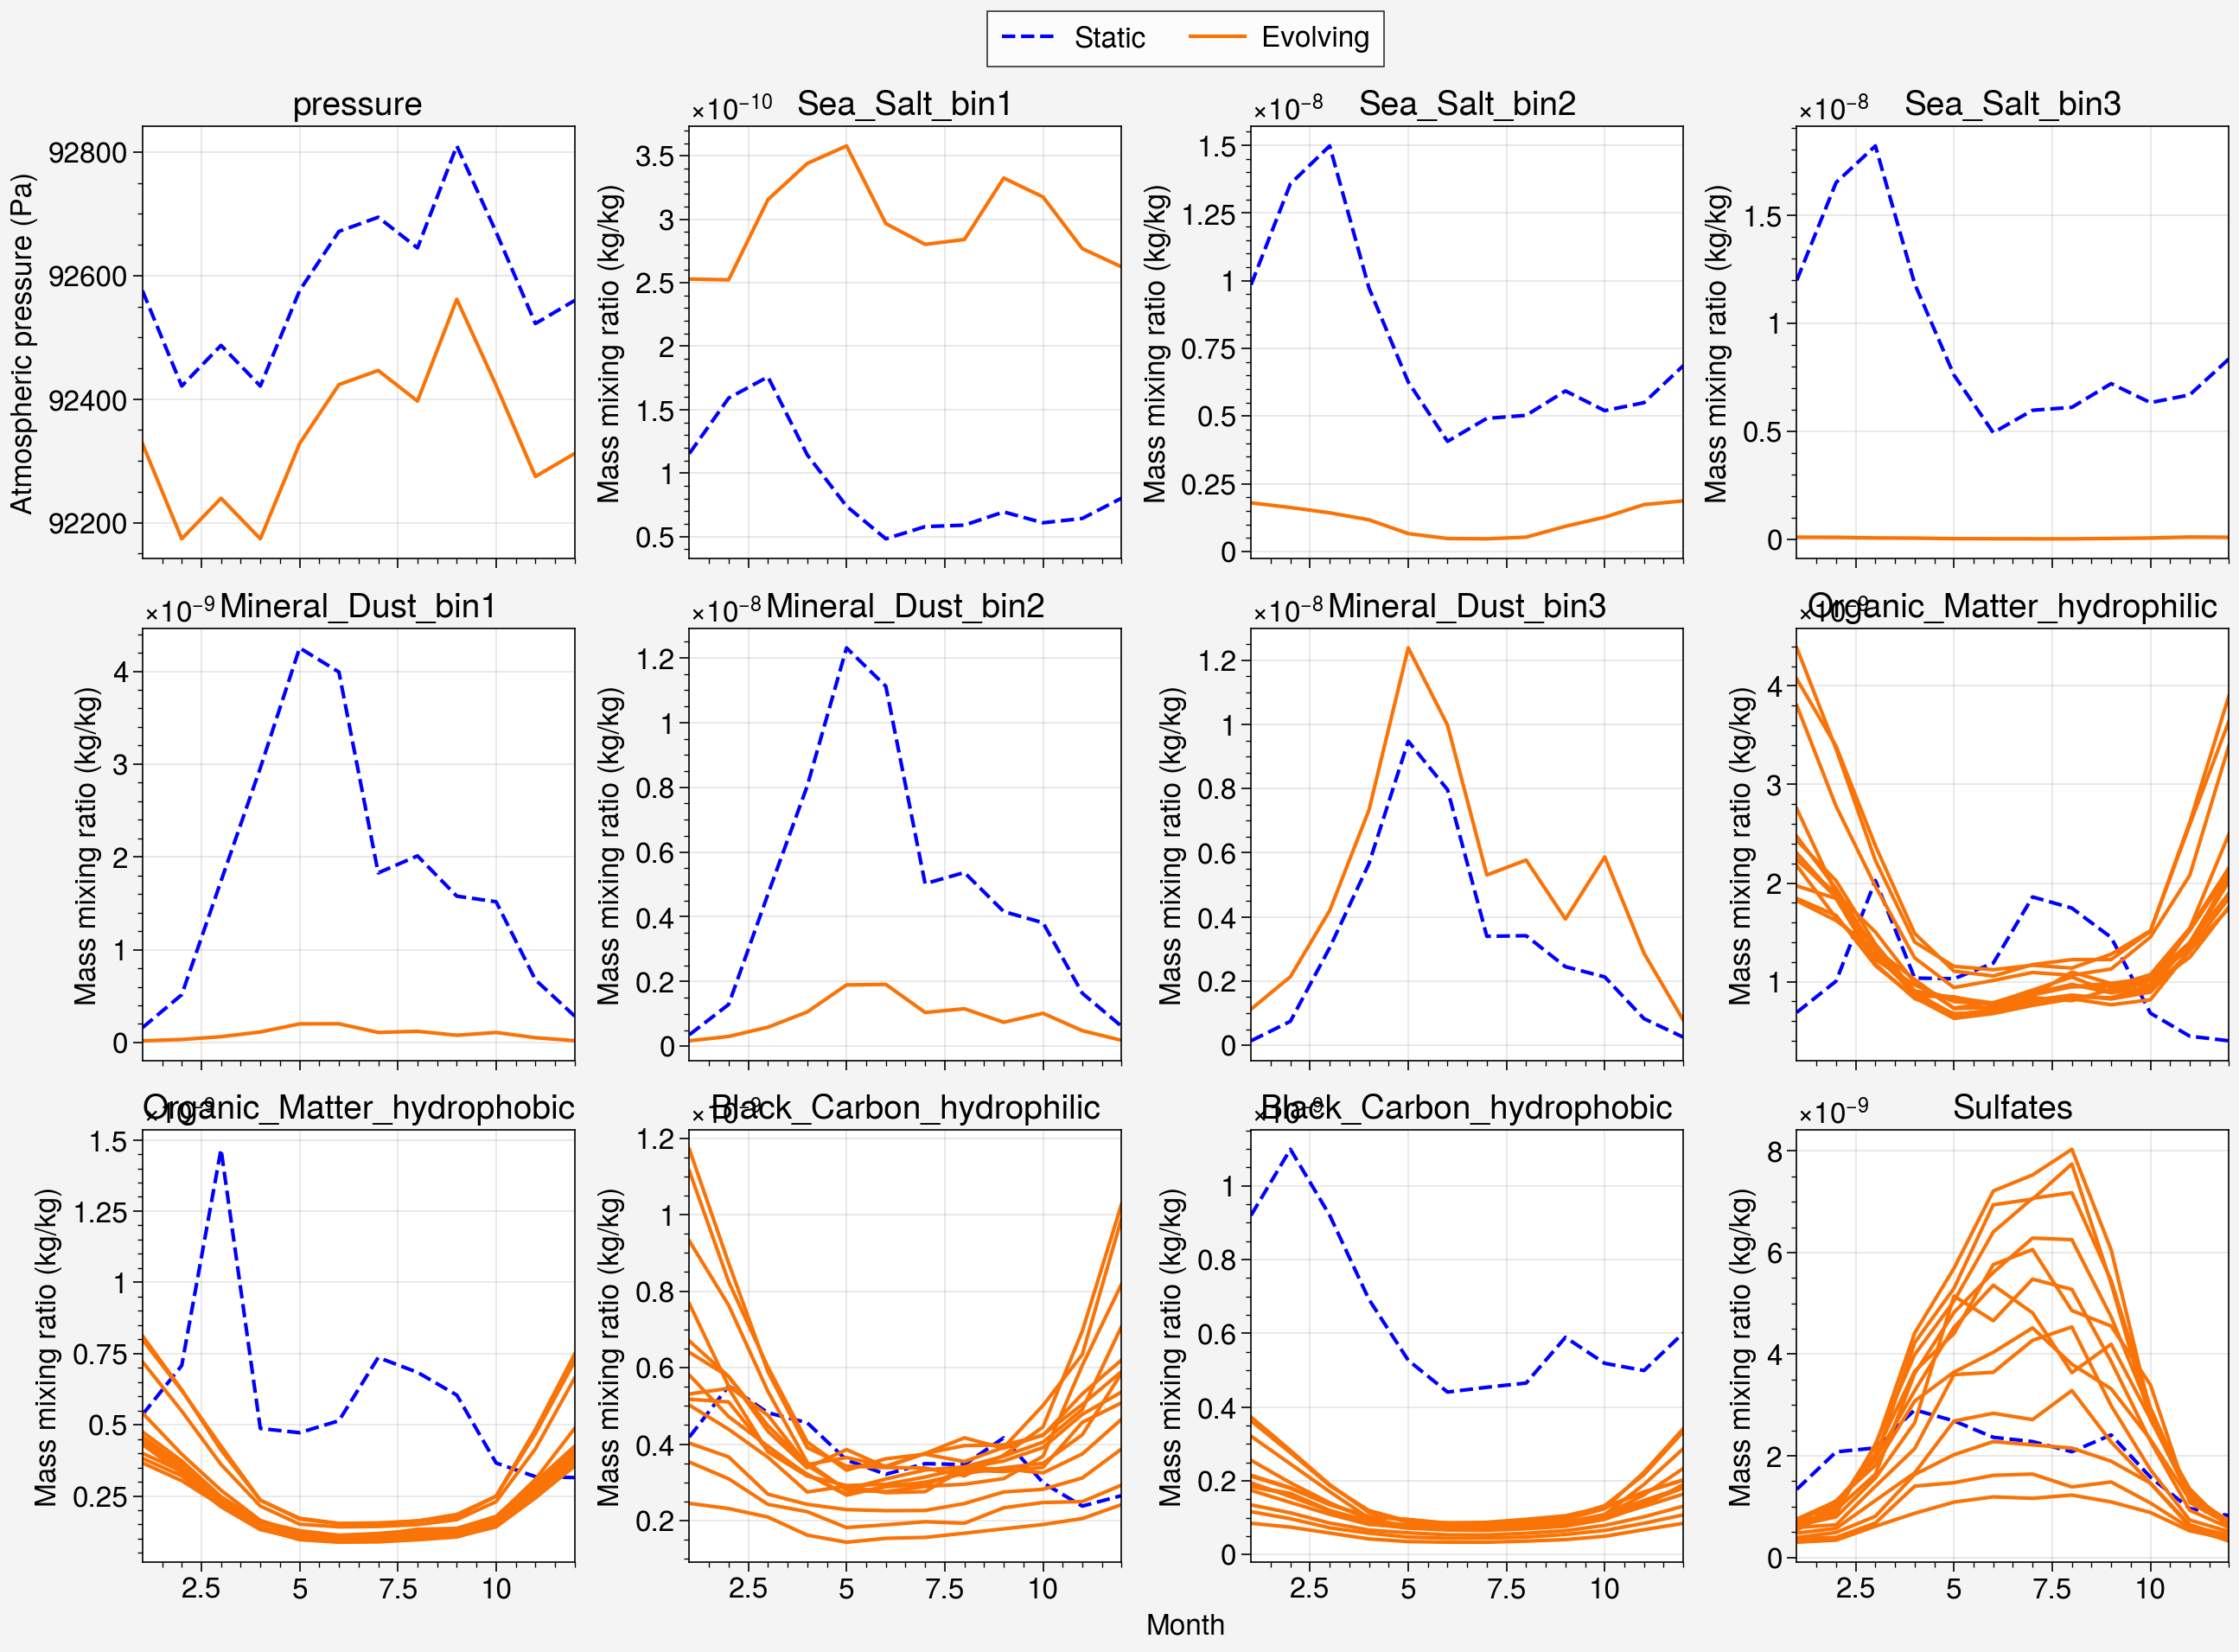

In [24]:
# pplt.rc.update(small=18, large=16)

var_selection = [
    "pressure",
    "Sea_Salt_bin1",
    "Sea_Salt_bin2",
    "Sea_Salt_bin3",
    "Mineral_Dust_bin1",
    "Mineral_Dust_bin2",
    "Mineral_Dust_bin3",
    "Organic_Matter_hydrophilic",
    "Organic_Matter_hydrophobic",
    "Black_Carbon_hydrophilic",
    "Black_Carbon_hydrophobic",
    "Sulfates",
]

f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False)

level = -1
Lat = 45
Lon = 6

for i in range(12):
    axs[i].format(title=var_selection[i])
    static = axs[i].plot(
        np.arange(1, 13, 1),
        ds_static[var_selection[i]].isel(lev=level).sel(lat = Lat, lon = Lon),
        linestyle="--",
        c="b",
        label="Static",
    )
    if i < 7:
        axs[i].plot(
            np.arange(1, 13, 1),
            ds_aerosols[var_selection[i]].isel(lev=level).sel(lat = Lat, lon = Lon),
            c="orange",
        )
    else:
        for epo in range(13):
            evolving = axs[i].plot(
                np.arange(1, 13, 1),
                ds_aerosols[var_selection[i]]
                .isel(epoch=epo)
                .isel(lev=level)
                .sel(lat = Lat, lon = Lon),
                c="orange",
                label="Evolving",
            )

f.legend([static, evolving], loc="top")
axs.format(xlabel="Month", ylabel="Mass mixing ratio (kg/kg)")
axs[0].format(ylabel="Atmospheric pressure (Pa)")

/tmp/ipykernel_1991428/1995436563.py:1: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=9, large=11)
/tmp/ipykernel_1991428/1995436563.py:1: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=9, large=11)


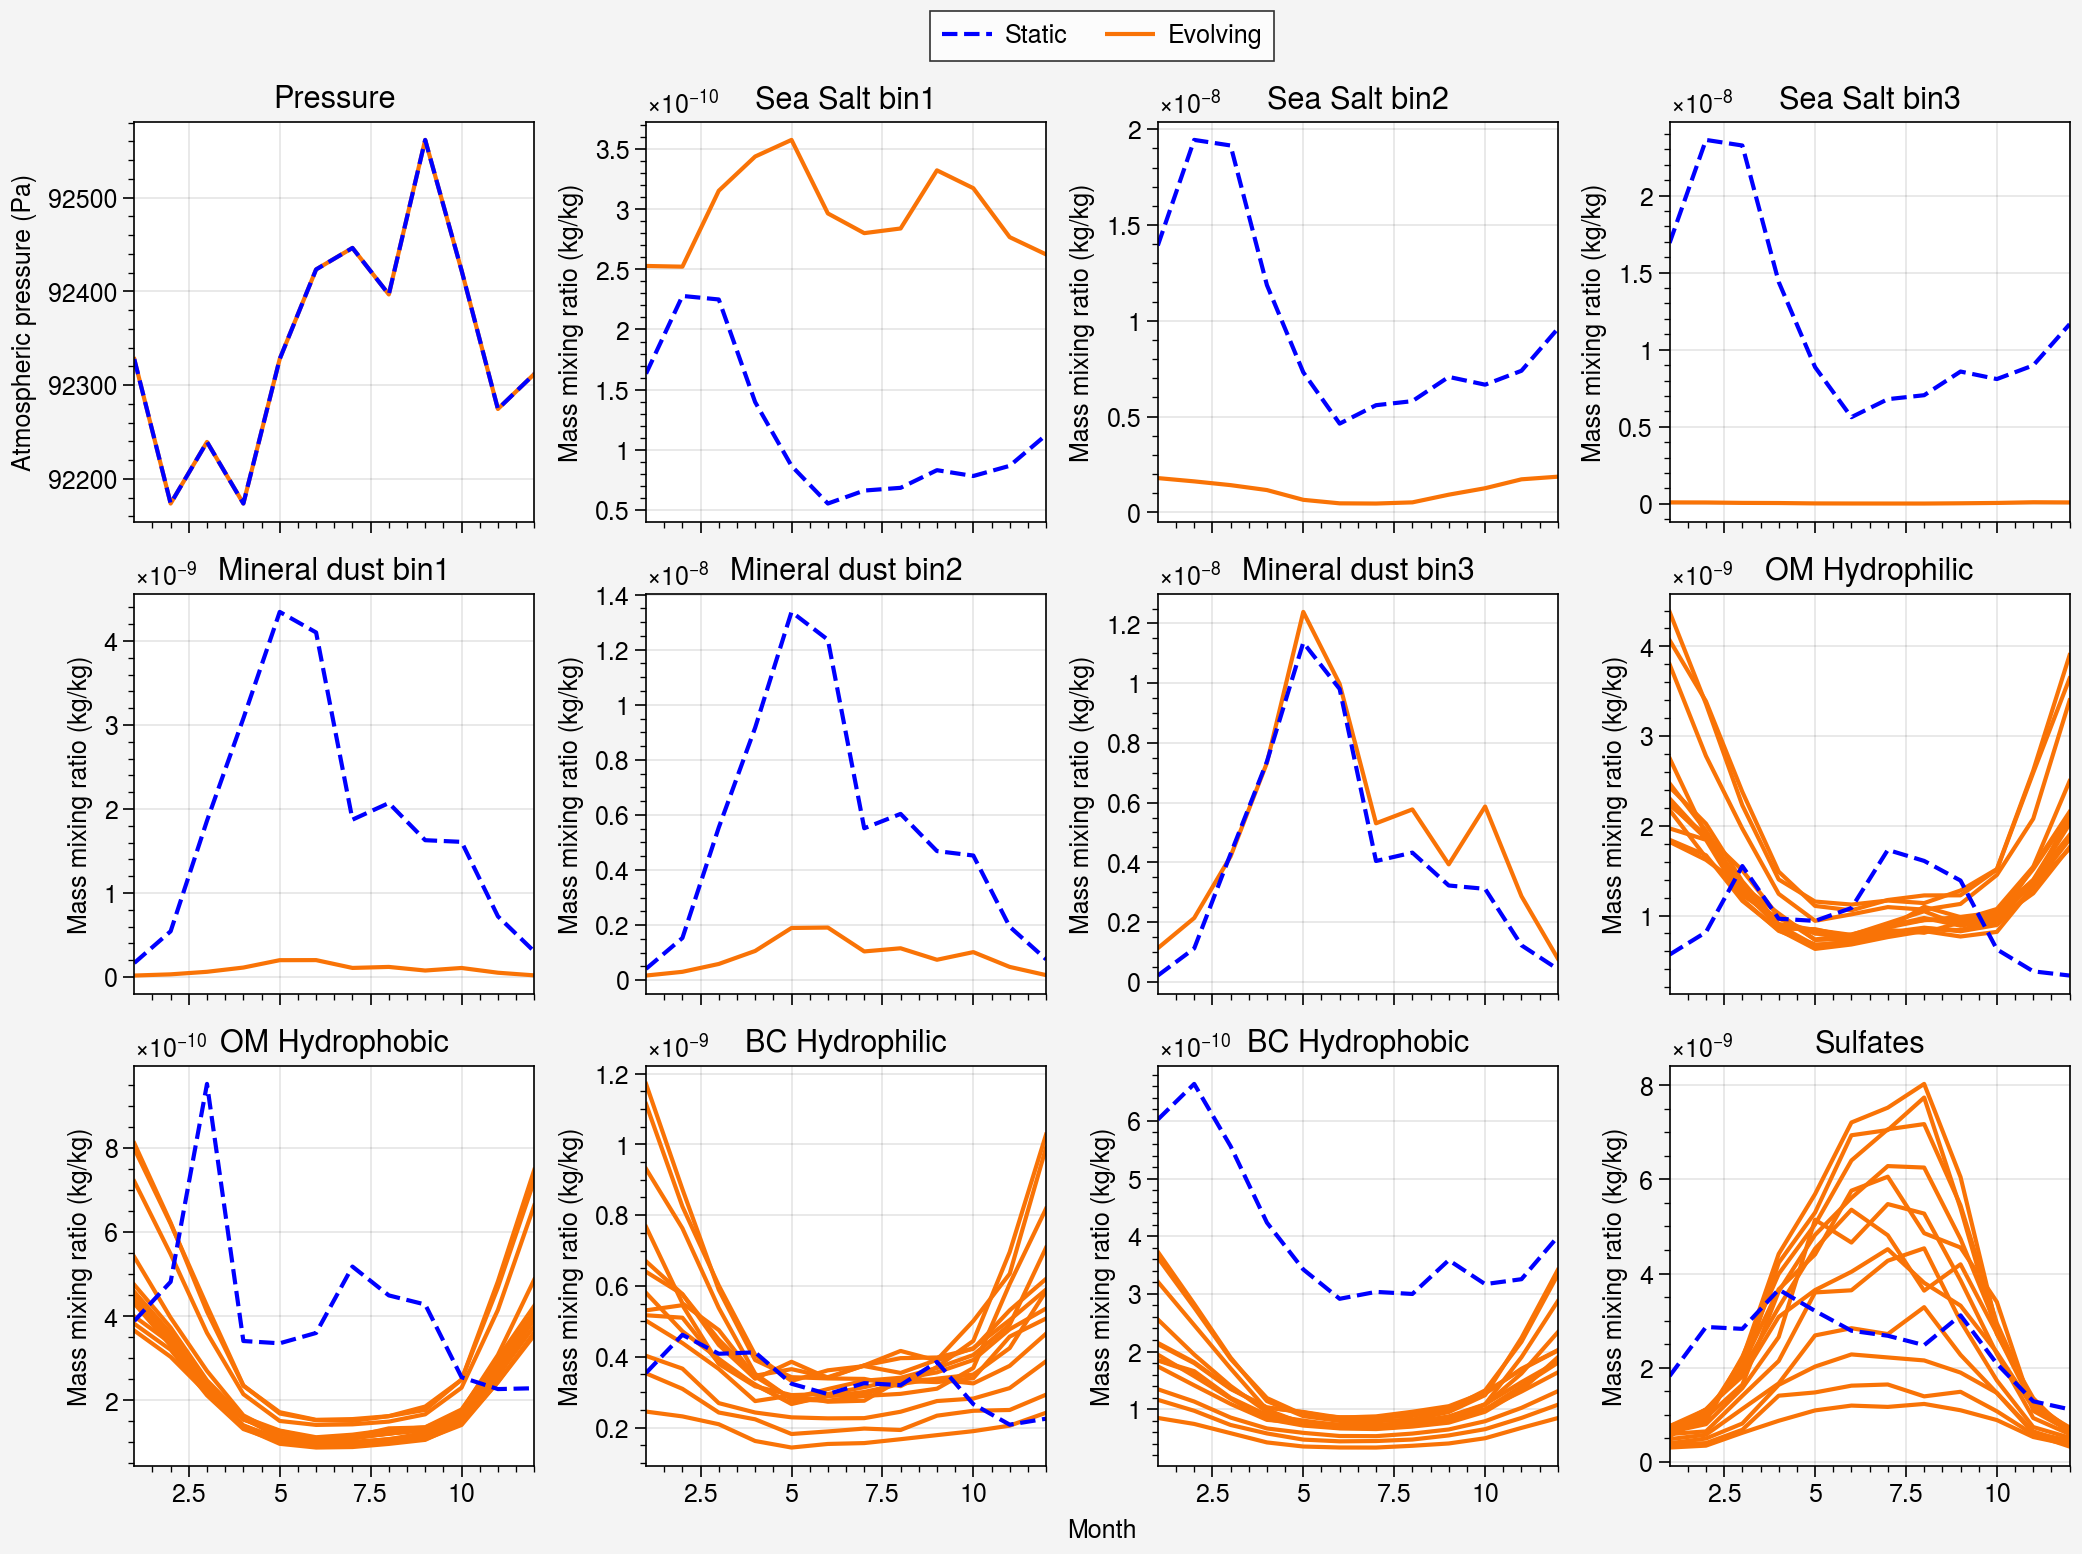

In [34]:
pplt.rc.update(small=9, large=11)
f, axs = pplt.subplots(ncols=4, nrows=3, sharey=False, axheight=2)

level = -1
Lat = 45
Lon = 6

xq = ds_aerosols.pressure.sel(lat = Lat,lon = Lon).isel(lev=-1)/100
x = ds_static.pressure.sel(lat=Lat, lon=Lon)/100

var_names = ['Pressure','Sea Salt bin1','Sea Salt bin2','Sea Salt bin3','Mineral dust bin1','Mineral dust bin2','Mineral dust bin3','OM Hydrophilic',
             'OM Hydrophobic','BC Hydrophilic','BC Hydrophobic','Sulfates']

for ivar in range(12):
    #axs[ivar].format(title=var_selection[ivar])
    axs[ivar].format(title=var_names[ivar])
    
    if ivar < 7:
        axs[ivar].plot(np.arange(1, 13, 1),
            ds_aerosols[var_selection[ivar]].isel(lev=level).sel(lat = Lat, lon = Lon),
            c="orange")
    else:
        for epo in range(13):
            evolving = axs[ivar].plot(np.arange(1, 13, 1),
                ds_aerosols[var_selection[ivar]].isel(epoch=epo, lev=level).sel(lat = Lat, lon = Lon),
                c="orange",label="Evolving")
    
    y = ds_static[var_selection[ivar]].sel(lat = Lat,lon = Lon)
    static = axs[ivar].plot(np.arange(1, 13, 1),
                            np.array([np.interp(xq[i], x[i], y[i]) for i in range(x.shape[0])]),
                            linestyle="--",c="b",label="Static")
    
f.legend([static, evolving], loc="top")
axs.format(xlabel="Month", ylabel="Mass mixing ratio (kg/kg)")
axs[0].format(ylabel="Atmospheric pressure (Pa)")

### CNRM Aerosols

In [35]:
ds_aerosols_CNRM = xr.open_dataset(
    "/bettik/menegozm/MAR_FORCING/ALADIN_aerosol/concbc_EUR-12_CNRM-ESM2-1_ssp126_r1i1p1f2_CNRM-MF_CNRM-ALADIN64E1_v1-r1_day_20150101-20151231.nc"
)

print(sys.getsizeof(ds_aerosols_CNRM))

112


In [36]:
ds_aerosols_CNRM

<xarray.Dataset>
Dimensions:            (y: 453, x: 453, nvertex: 4, plev: 19, time: 365,
                        axis_nbounds: 2)
Coordinates:
    lat                (y, x) float64 ...
    lon                (y, x) float64 ...
  * plev               (plev) float32 1e+05 9.75e+04 9.5e+04 ... 2.5e+04 2e+04
  * time               (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-...
  * x                  (x) float64 0.0 12.5 25.0 ... 5.638e+03 5.65e+03
  * y                  (y) float64 0.0 12.5 25.0 ... 5.638e+03 5.65e+03
Dimensions without coordinates: nvertex, axis_nbounds
Data variables:
    bounds_lon         (y, x, nvertex) float64 ...
    bounds_lat         (y, x, nvertex) float64 ...
    time_bounds        (time, axis_nbounds) datetime64[ns] ...
    concbc             (time, plev, y, x) float32 ...
    Lambert_Conformal  int32 ...
Attributes: (12/41)
    name:                    /scratch/work/nabat/ALADIN/EUC12-CMIP6-SSP126-CN...
    description:             Created by xios
    creation_date:           2024-03-25T10:15:12Z
    title:                   CNRM-ALADIN64E1 model output prepared for CORDEX...
    activity_id:             DD
    comment:                 CORDEX EUR-12 CNRM-ALADIN64E1 L91.
    ...                      ...
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    license:                 CORDEX model data produced by CNRM-MF is license...
    source:                  CNRM-ALADIN regional climate model, version 6.4 E1
    source_type:             ARCM
    grid:                    Lambert conic conformal with 12.5 km grid spacing
    tracking_id:             hdl:21.14103/cad360a7-246b-4f75-b218-8500d7323ca0

In [37]:
lon = np.array(ds_aerosols_CNRM.lon)
print(lon.shape)
print(lon.max())
print(lon.min())

(453, 453)
72.56399488851537
-51.563994888515396


In [38]:
lat = np.array(ds_aerosols_CNRM.lat)
print(lat.shape)
print(lat.max())
print(lat.min())

(453, 453)
73.96581452066758
20.98008124047134


In [39]:
np.array(ds_aerosols_CNRM.concbc.isel(plev=0,time=0,y=250))


array([1.84954482e-12, 1.84096033e-12, 1.85176852e-12, 1.87635150e-12,
       1.89394290e-12, 1.91071659e-12, 1.95013862e-12, 1.97776366e-12,
       2.00860357e-12, 2.05235286e-12, 2.09545510e-12, 2.15971685e-12,
       2.20050649e-12, 2.23178854e-12, 2.26641470e-12, 2.29048096e-12,
       2.29969169e-12, 2.33018357e-12, 2.35039137e-12, 2.38947273e-12,
       2.43584623e-12, 2.47085100e-12, 2.50956938e-12, 2.55108261e-12,
       2.58192751e-12, 2.59375529e-12, 2.58218382e-12, 2.59251258e-12,
       2.58167901e-12, 2.55255214e-12, 2.51805369e-12, 2.51203637e-12,
       2.54410967e-12, 2.57608214e-12, 2.60811880e-12, 2.61604822e-12,
       2.64679359e-12, 2.66940896e-12, 2.69052402e-12, 2.71155212e-12,
       2.71162498e-12, 2.70226116e-12, 2.66943802e-12, 2.64876489e-12,
       2.63272520e-12, 2.62624384e-12, 2.61219670e-12, 2.60164026e-12,
       2.59593345e-12, 2.58686757e-12, 2.57428280e-12, 2.63612244e-12,
       2.61139678e-12, 2.58103977e-12, 2.47976878e-12, 2.31286127e-12,
      

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


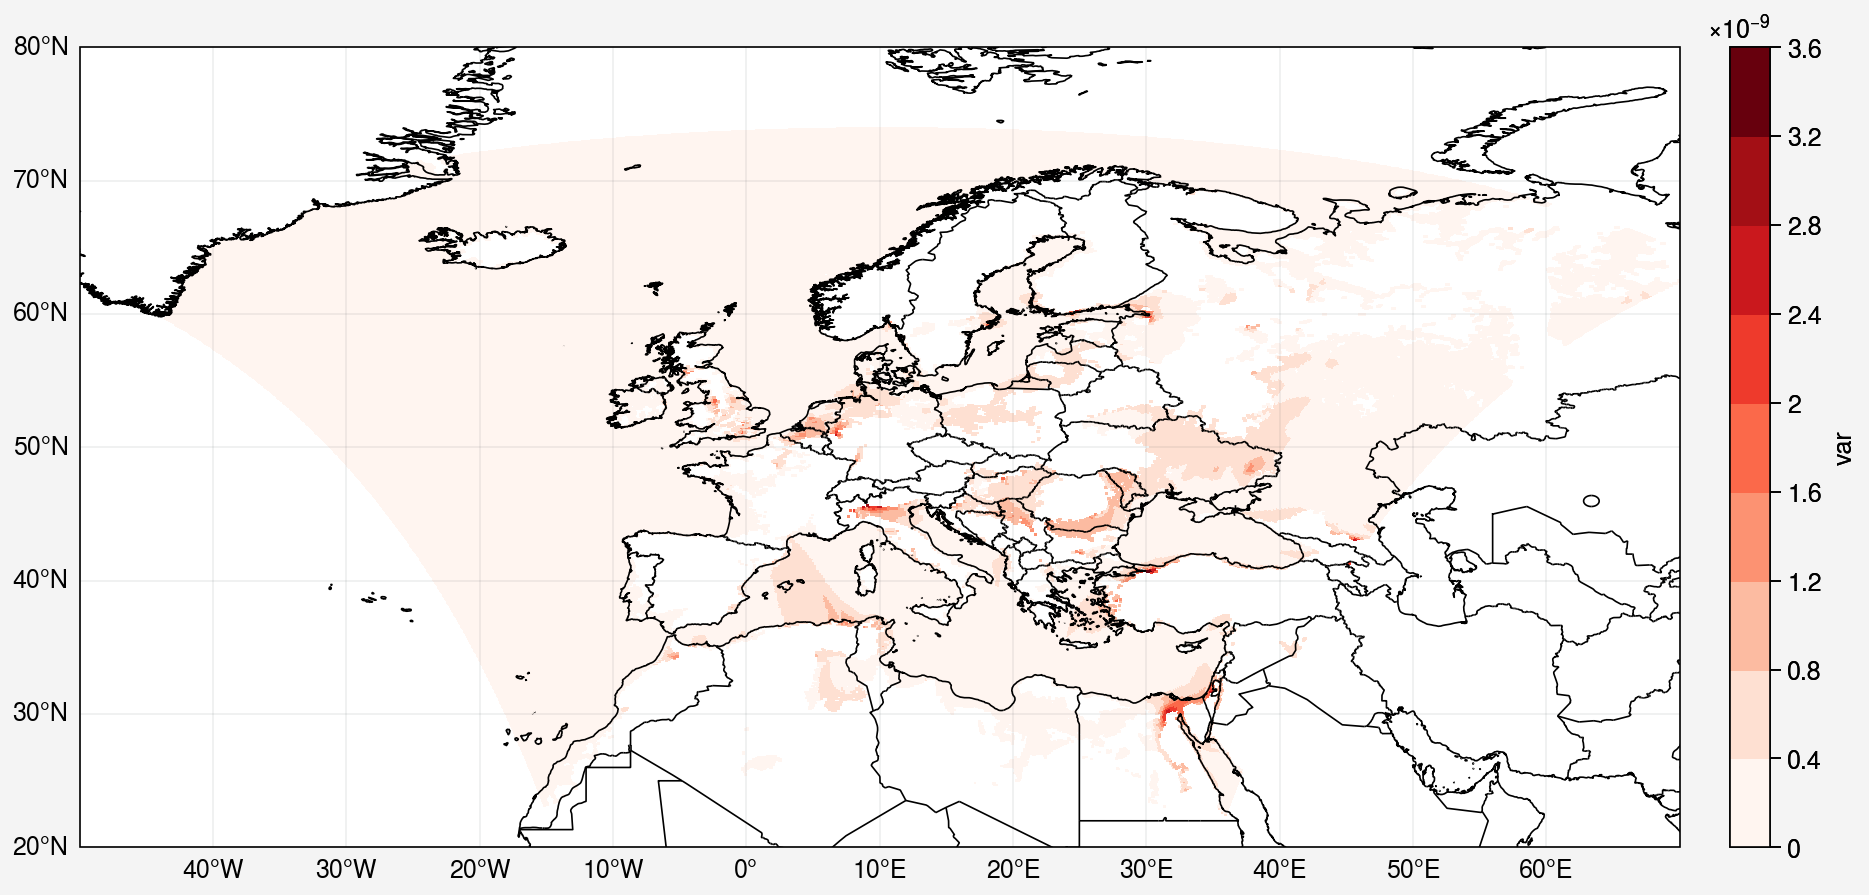

In [14]:
normal_format2 = {
    "gridlinewidth": 0.1,
    "gridcolor": "gray8",
    "gridalpha": 0.5,
    "coast": True,
    "borders": True,
    "reso": "hi",
    "labels": True,
    "lonlines": 10,
    "latlines": 10,
    "abc": False,
    "latlim": [20.0, 80.0],
    "lonlim": [-50.0, 70.0],
}

f, axs = pplt.subplots(proj="cyl", axwidth=8)


m = axs.pcolormesh(lon, lat, ds_aerosols_CNRM.concbc.isel(plev=0,time=1), levels=10, cmap="Reds")
f.colorbar(m, label="var")

axs.format(**normal_format2)

In [ ]:
f, axs = pplt.subplots(proj="cyl", axwidth=6,ncols=4, nrows=3)

for i in range(2):
    
    m = axs.pcolormesh(ds_aerosols_CNRM.lon, ds_aerosols_CNRM.lat, ds_aerosols_CNRM.concbc.mean(axis=0).isel(plev=i), levels=10, cmap="Reds")

f.colorbar(m, label="BC concentration")


axs.format(**normal_format)
axs.format(
    ocean=True, oceancolor="lightgray", reso="hi"
)  # , latlim=[40.,51.],lonlim=[0.,20.])

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx